<a href="https://colab.research.google.com/github/AnnetteJohn/AnnetteJohn/blob/main/June_Baseline_Rerun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Data Extration from MIMIC-Note


In [2]:
!pip install dask pandas

In [3]:
import dask.dataframe as dd
import pandas as pd


In [4]:
# I ran only this cell for the last consolidated dataset on 22nd feb
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from collections import Counter

# Load discharge summaries and radiology reports
discharge_notes = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Note/note/discharge.csv.gz")
radiology_notes = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Note/note/radiology.csv.gz")

# Convert to pandas for analysis (we'll do this first to understand our data)
print("Loading notes into memory...")
discharge_df = discharge_notes.compute()
radiology_df = radiology_notes.compute()



/usr/local/lib/python3.11/dist-packages/dask/backends.py:140: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/dask/backends.py:140: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  return func(*args, **kwargs)


Loading notes into memory...


In [5]:
# Get prostate cancer patients
# Diagnoses data
diagnoses = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/diagnoses_icd.csv.gz",
                       compression="gzip", blocksize=None)
print("Identifying prostate cancer patients...")
prostate_codes = ['185', 'C61']  # ICD-9 and ICD-10
pc_diagnoses = diagnoses[diagnoses.icd_code.isin(prostate_codes)].compute()


Identifying prostate cancer patients...


In [6]:
pc_subject_ids = pc_diagnoses.subject_id.unique()
print(f"Found {len(pc_subject_ids)} prostate cancer patients")

Found 2497 prostate cancer patients


In [7]:
# Filter notes to only prostate cancer patients
discharge_prostate = discharge_df[discharge_df['subject_id'].isin(pc_subject_ids)]
radiology_prostate = radiology_df[radiology_df['subject_id'].isin(pc_subject_ids)]

In [8]:
# Basic statistics prostate specific
print("\nBasic Statistics:")
print(f"Number of prostate discharge summaries: {len(discharge_prostate)}")
print(f"Number of prostate radiology reports: {len(radiology_prostate)}")
print(f"Unique patients in prostate discharge summaries: {discharge_prostate['subject_id'].nunique()}")
print(f"Unique patients in prostate radiology reports: {radiology_prostate['subject_id'].nunique()}")



Basic Statistics:
Number of prostate discharge summaries: 6344
Number of prostate radiology reports: 35360
Unique patients in prostate discharge summaries: 1969
Unique patients in prostate radiology reports: 2017


In [9]:
# Basic text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and extra whitespace
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)  # Remove deidentified brackets
    text = re.sub(r'\n', ' ', text)              # Replace newlines with space
    text = re.sub(r'\s+', ' ', text)             # Replace multiple spaces
    text = text.strip()                          # Remove leading/trailing whitespace
    return text



In [10]:
# Clean the notes (prostate-specific)
print("\nCleaning notes (prostate-specific)...")
discharge_prostate['clean_text'] = discharge_prostate['text'].apply(clean_text)
radiology_prostate['clean_text'] = radiology_prostate['text'].apply(clean_text)



Cleaning notes (prostate-specific)...


<ipython-input-10-3482415207>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_prostate['clean_text'] = discharge_prostate['text'].apply(clean_text)
<ipython-input-10-3482415207>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiology_prostate['clean_text'] = radiology_prostate['text'].apply(clean_text)


In [11]:
# Get note lenghts for prostate-specific patients
discharge_prostate['note_length'] = discharge_prostate['clean_text'].str.len()
radiology_prostate['note_length'] = radiology_prostate['clean_text'].str.len()


<ipython-input-11-766323508>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_prostate['note_length'] = discharge_prostate['clean_text'].str.len()
<ipython-input-11-766323508>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiology_prostate['note_length'] = radiology_prostate['clean_text'].str.len()


In [12]:
# Convert chartdate/charttime to datetime
discharge_prostate['charttime'] = pd.to_datetime(discharge_prostate['charttime'])
radiology_prostate['charttime'] = pd.to_datetime(radiology_prostate['charttime'])



<ipython-input-12-2244931173>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_prostate['charttime'] = pd.to_datetime(discharge_prostate['charttime'])
<ipython-input-12-2244931173>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiology_prostate['charttime'] = pd.to_datetime(radiology_prostate['charttime'])


In [13]:
# Basic EDA (prostate specific)
print("\nNote Length Statistics:")
print("\nDischarge Summaries prostate specific:")
print(discharge_prostate['note_length'].describe())
print("\nRadiology Reports prostate specific:")
print(radiology_prostate['note_length'].describe())




Note Length Statistics:

Discharge Summaries prostate specific:
count     6344.000000
mean     10410.965952
std       4161.917928
min        527.000000
25%       7547.500000
50%       9698.000000
75%      12560.000000
max      40333.000000
Name: note_length, dtype: float64

Radiology Reports prostate specific:
count    35360.000000
mean      1310.885181
std       1117.622956
min         10.000000
25%        540.000000
50%        847.000000
75%       1759.000000
max      10318.000000
Name: note_length, dtype: float64


In [ ]:
discharge_prostate

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,clean_text,note_length
268,10006716-DS-6,10006716,21249009,DS,6,2183-02-13,2183-02-14 13:19:00,Name: ___ Unit No: ___ Admi...,name: ___ unit no: ___ admission date: ___ dis...,5725
361,10011126-DS-22,10011126,26463677,DS,22,2155-11-24,2155-11-30 14:40:00,Name: ___ Unit No: ___...,name: ___ unit no: ___ admission date: ___ dis...,8520
362,10011126-DS-23,10011126,24701479,DS,23,2156-02-26,2156-03-07 20:37:00,Name: ___ Unit No: ___...,name: ___ unit no: ___ admission date: ___ dis...,8262
496,10014610-DS-21,10014610,23424056,DS,21,2168-08-06,2168-08-06 14:34:00,Name: ___ Unit No: ___ ...,name: ___ unit no: ___ admission date: ___ dis...,8220
497,10014610-DS-22,10014610,27041220,DS,22,2168-08-21,2168-08-21 10:40:00,Name: ___ Unit No: ___ ...,name: ___ unit no: ___ admission date: ___ dis...,9541
...,...,...,...,...,...,...,...,...,...,...
331438,19989783-DS-20,19989783,25490687,DS,20,2126-08-28,2126-09-01 14:18:00,Name: ___ Unit No: ___ ...,name: ___ unit no: ___ admission date: ___ dis...,11308
331439,19989783-DS-21,19989783,22784678,DS,21,2128-06-21,2128-06-21 22:19:00,Name: ___ Unit No: ___ ...,name: ___ unit no: ___ admission date: ___ dis...,15194
331440,19989783-DS-22,19989783,23110090,DS,22,2130-03-26,2130-03-26 23:42:00,Name: ___ Unit No: ___ ...,name: ___ unit no: ___ admission date: ___ dis...,16022
331441,19989783-DS-23,19989783,26984195,DS,23,2130-08-01,2130-08-01 15:01:00,Name: ___ Unit No: ___ ...,name: ___ unit no: ___ admission date: ___ dis...,8551


In [ ]:
radiology_prostate

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,clean_text,note_length
1969,10006716-RR-16,10006716,NaN,RR,16,2182-09-10 08:31:00,2182-09-10 12:54:00,HISTORY: ___ man with history of prostate can...,history: ___ man with history of prostate canc...,1960
1970,10006716-RR-19,10006716,NaN,RR,19,2185-02-15 14:28:00,2185-02-15 17:07:00,EXAMINATION: MR LUMBAR SPINE WITH AND WITHOUT...,examination: mr lumbar spine with and without ...,1546
2595,10011126-RR-23,10011126,26463677.0,RR,23,2155-11-20 12:26:00,2155-11-20 12:50:00,HISTORY: ___ male with abdominal pain and fev...,history: ___ male with abdominal pain and feve...,387
2596,10011126-RR-24,10011126,26463677.0,RR,24,2155-11-20 12:10:00,2155-11-20 23:28:00,"INDICATION: ___ man with abdominal pain, feve...","indication: ___ man with abdominal pain, fever...",1974
2597,10011126-RR-25,10011126,24701479.0,RR,25,2156-02-24 04:32:00,2156-02-24 07:35:00,INDICATION: Nausea and vomiting. COMPARISON:...,indication: nausea and vomiting. comparison: _...,260
...,...,...,...,...,...,...,...,...,...,...
2319106,19989783-RR-50,19989783,24282820.0,RR,50,2130-08-02 23:13:00,2130-08-03 11:57:00,EXAMINATION: CHEST (PORTABLE AP) INDICATION:...,examination: chest (portable ap) indication: _...,767
2319107,19989783-RR-51,19989783,24282820.0,RR,51,2130-08-04 09:51:00,2130-08-04 17:42:00,"INDICATION: ___ with NICM (EF 25% ___, CKD St...","indication: ___ with nicm (ef 25% ___, ckd sta...",1790
2319108,19989783-RR-54,19989783,NaN,RR,54,2130-11-07 09:51:00,2130-11-07 16:51:00,"EXAMINATION: US ABD LIMIT, SINGLE ORGAN PORT ...","examination: us abd limit, single organ port i...",517
2319109,19989783-RR-8,19989783,25490687.0,RR,8,2126-08-11 19:23:00,2126-08-11 20:50:00,EXAMINATION: CHEST (PORTABLE AP) INDICATION:...,examination: chest (portable ap) indication: _...,559


## Loading structured tables

In [14]:
# 1. Load Structured Tables
print("Loading structured tables...")

# Core patient data
patients = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/patients.csv.gz",
                      compression="gzip", blocksize=None)

# Admissions data
admissions = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/admissions.csv.gz",
                        compression="gzip", dtype={"deathtime": "object"}, blocksize=None)


Loading structured tables...


In [15]:
print(f"Found {len(pc_subject_ids)} prostate cancer patients")

Identifying prostate cancer patients...
Found 2497 prostate cancer patients


In [ ]:
import numpy as np
#Save these subject ids to Drive
np.save('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_PatientIDs/prostate_cancer_subject_ids.npy', pc_subject_ids)


In [ ]:
#Save Diagnoses to Drive
pc_diagnoses.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Diagnoses/pc_diagnoses.csv', index=False)

In [16]:
# Process Structured Data
print("\nProcessing structured data...")

# Get patient demographics
pc_patients = patients[patients.subject_id.isin(pc_subject_ids)].compute()
pc_admissions = admissions[admissions.subject_id.isin(pc_subject_ids)].compute()

# Basic demographics analysis
print("\nDemographic Statistics:")
print("\nAge Distribution:")
print(pc_patients['anchor_age'].describe())


Processing structured data...

Demographic Statistics:

Age Distribution:
count    2497.000000
mean       70.762515
std        11.466929
min        25.000000
25%        62.000000
50%        70.000000
75%        80.000000
max        91.000000
Name: anchor_age, dtype: float64


In [ ]:
#Save this information to Drive
pc_patients.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Patients/pc_patients.csv', index=False)
pc_admissions.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Admissions/pc_admissions.csv', index=False)

In [ ]:
pc_admissions # this contains admit and discharge times, but does not contain gender, but it also contains the hospital_expire_flag which tells us if the patient is dead or not, but does not give us time of death

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
419,10006716,21249009,2183-02-12 07:15:00,2183-02-13 11:25:00,<NA>,ELECTIVE,P61ON4,PHYSICIAN REFERRAL,HOME,Private,English,MARRIED,WHITE,<NA>,<NA>,0
420,10006716,23161830,2191-11-06 15:39:00,2191-11-09 13:15:00,<NA>,OBSERVATION ADMIT,P086OF,WALK-IN/SELF REFERRAL,HOME,Medicare,English,MARRIED,OTHER,2191-11-06 10:21:00,2191-11-06 21:09:00,0
421,10006716,24348100,2193-01-07 19:21:00,2193-01-12 16:45:00,<NA>,OBSERVATION ADMIT,P690UI,WALK-IN/SELF REFERRAL,HOME,Medicare,English,MARRIED,WHITE,2193-01-07 11:22:00,2193-01-07 21:29:00,0
422,10006716,26174018,2192-08-21 13:39:00,2192-08-22 19:36:00,<NA>,OBSERVATION ADMIT,P76H5F,WALK-IN/SELF REFERRAL,HOME,Medicare,English,MARRIED,WHITE,2192-08-21 08:28:00,2192-08-21 14:33:00,0
623,10011126,24701479,2156-02-24 04:57:00,2156-02-26 15:00:00,<NA>,EW EMER.,P35WW6,EMERGENCY ROOM,HOME,Medicare,English,MARRIED,WHITE,2156-02-24 03:36:00,2156-02-24 06:55:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545424,19989783,23110090,2130-03-15 22:37:00,2130-03-26 16:30:00,<NA>,OBSERVATION ADMIT,P2915M,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,English,SINGLE,BLACK/AFRICAN AMERICAN,2130-03-15 13:24:00,2130-03-16 00:01:00,0
545425,19989783,24282820,2130-08-02 17:27:00,2130-08-07 13:46:00,<NA>,EW EMER.,P07KMB,WALK-IN/SELF REFERRAL,CHRONIC/LONG TERM ACUTE CARE,Medicare,English,SINGLE,BLACK/AFRICAN AMERICAN,2130-08-02 12:52:00,2130-08-02 18:31:00,0
545426,19989783,25490687,2126-08-11 00:00:00,2126-08-28 12:53:00,<NA>,DIRECT EMER.,P32VJE,PHYSICIAN REFERRAL,HOME HEALTH CARE,Private,English,SINGLE,BLACK/AFRICAN AMERICAN,<NA>,<NA>,0
545427,19989783,26984195,2130-07-12 08:34:00,2130-08-01 15:50:00,<NA>,OBSERVATION ADMIT,P42XKM,PHYSICIAN REFERRAL,CHRONIC/LONG TERM ACUTE CARE,Medicare,English,SINGLE,BLACK/AFRICAN AMERICAN,2130-07-12 06:35:00,2130-07-12 09:01:00,0


In [ ]:
pc_patients #this tells us if the patient has expired or not and when along with age and gender

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
260,10006716,M,61,2183,2011 - 2013,<NA>
416,10011126,M,73,2155,2011 - 2013,2156-03-15
537,10014610,M,66,2166,2008 - 2010,<NA>
657,10017733,M,78,2114,2020 - 2022,<NA>
790,10021454,M,88,2125,2020 - 2022,2125-03-24
...,...,...,...,...,...,...
363388,19965744,M,87,2177,2020 - 2022,2178-05-31
363663,19973319,M,89,2120,2017 - 2019,<NA>
363718,19974907,M,63,2130,2014 - 2016,<NA>
363899,19979725,M,81,2143,2011 - 2013,<NA>


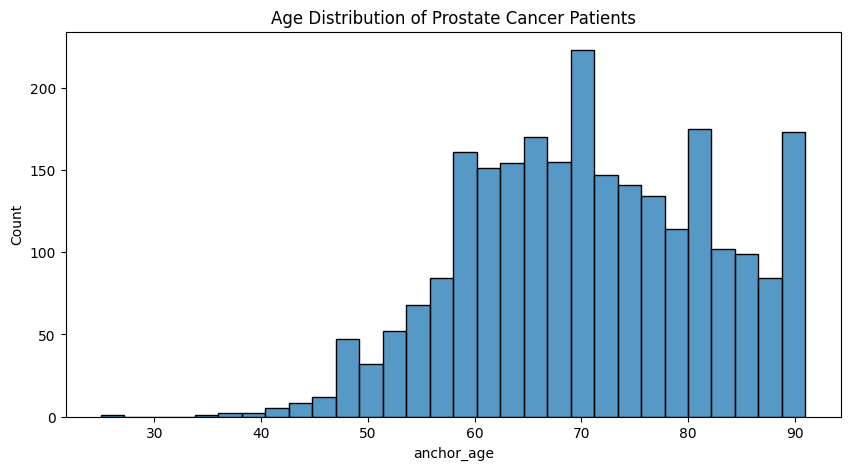

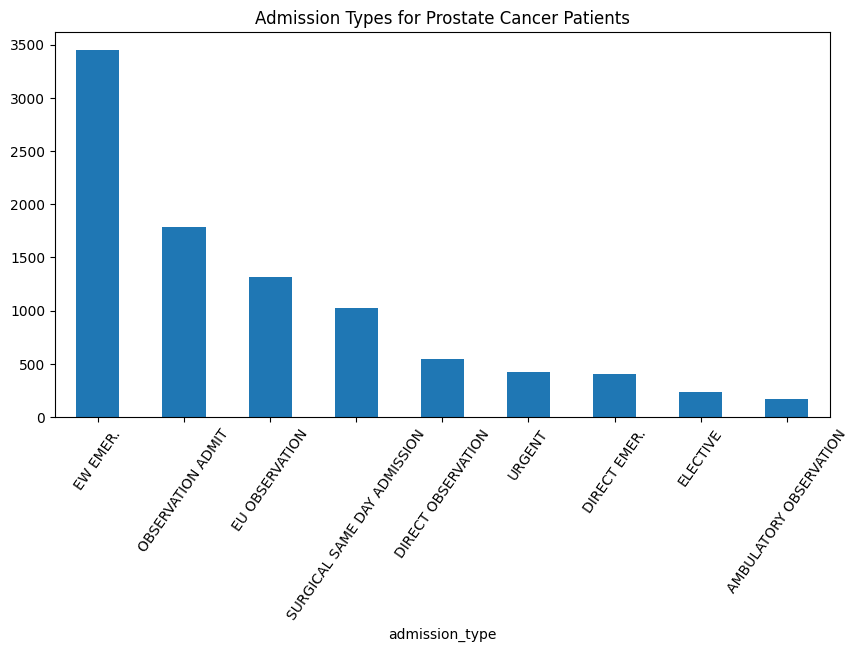

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=pc_patients, x='anchor_age', bins=30)
plt.title('Age Distribution of Prostate Cancer Patients')
plt.show()

# Admission types analysis
plt.figure(figsize=(10, 5))
pc_admissions['admission_type'].value_counts().plot(kind='bar')
plt.title('Admission Types for Prostate Cancer Patients')
plt.xticks(rotation=55)
plt.show()

In [ ]:
# Loading the pc patients id
# Only implementing this for the final dataset 23rd feb

In [17]:
pc_subject_ids_list = pc_subject_ids.tolist()
pc_subject_ids_set = set(pc_subject_ids)

In [18]:
pc_relevant_labs = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/pc_relevant_labs.csv')

In [19]:
# Handle missing values
# For valuenum (numeric results)
pc_relevant_labs['valuenum'] = pc_relevant_labs['valuenum'].fillna(0)

# Group by patient and test type to identify missing tests
patient_test_coverage = pc_relevant_labs.groupby(['subject_id', 'itemid']).size().unstack(fill_value=0)
print(f"Test coverage by patient:\n{patient_test_coverage.describe()}")



Test coverage by patient:
itemid        50863        50894        50912        50974        50988
count   2494.000000  2494.000000  2494.000000  2494.000000  2494.000000
mean      13.861267     0.136728    36.186447     7.215317     1.824779
std       28.477843     0.649099    50.312439    11.483841     4.854168
min        0.000000     0.000000     1.000000     0.000000     0.000000
25%        1.000000     0.000000     8.000000     0.000000     0.000000
50%        5.000000     0.000000    20.000000     3.000000     0.000000
75%       15.000000     0.000000    44.750000     9.000000     1.000000
max      337.000000    13.000000   573.000000   102.000000    79.000000


In [20]:
# Only include patients with at least 3 PSA measurements
patients_with_sufficient_psa = patient_test_coverage[patient_test_coverage[50974] >= 3].index

In [21]:
# Prioritize tests with better coverage for time-series features
priority_tests = [50974, 50863, 50912]  # PSA, ALP, Creatinine

In [22]:
def create_patient_sequences(patient_id, min_tests=3, test_ids=[50974, 50863, 50912], max_seq_length=20):
    """
    Create time-aligned lab test sequences for a patient

    Args:
        patient_id: Patient identifier
        min_tests: Minimum number of PSA tests required
        test_ids: List of test IDs to include (PSA, ALP, Creatinine)
        max_seq_length: Maximum sequence length to return

    Returns:
        Dictionary with patient sequences or None if insufficient data
    """
    # Get all lab data for this patient
    patient_data = pc_relevant_labs[pc_relevant_labs.subject_id == patient_id]

    # Check if patient has minimum required PSA tests
    psa_tests = patient_data[patient_data.itemid == 50974]
    if len(psa_tests) < min_tests:
        return None  # Skip patients with insufficient data

    # Sort all patient data by time
    patient_data = patient_data.sort_values('charttime')

    # Get unique timestamps (we'll align all tests to these)
    timestamps = sorted(patient_data['charttime'].unique())

    # If we have too many timestamps, keep the most recent ones
    if len(timestamps) > max_seq_length:
        timestamps = timestamps[-max_seq_length:]

    # Initialize sequence arrays for each test type
    sequences = {test_id: np.zeros(len(timestamps)) for test_id in test_ids}

    # Fill in values for each test at corresponding timestamps
    for test_id in test_ids:
        test_data = patient_data[patient_data.itemid == test_id]

        # For each timestamp, find the closest test value
        for i, timestamp in enumerate(timestamps):
            # Find tests on or before this timestamp
            prior_tests = test_data[test_data['charttime'] <= timestamp]

            if len(prior_tests) > 0:
                # Get the most recent test value
                latest_test = prior_tests.iloc[-1]
                sequences[test_id][i] = latest_test['valuenum']
            elif i > 0:
                # If no prior test, carry forward the previous value
                sequences[test_id][i] = sequences[test_id][i-1]

    # Create a dictionary with aligned sequences
    result = {
        'subject_id': patient_id,
        'timestamps': timestamps,
        'sequences': np.array([sequences[test_id] for test_id in test_ids]).T,  # Shape: [time_steps, features]
        'feature_names': [f"Test_{test_id}" for test_id in test_ids]
    }

    return result



In [23]:
# Apply to all patients
patient_sequences = {}
for patient_id in pc_relevant_labs['subject_id'].unique():
    sequence = create_patient_sequences(patient_id)
    if sequence is not None:
        patient_sequences[patient_id] = sequence

print(f"Created sequences for {len(patient_sequences)} patients")



Created sequences for 1267 patients



Example for patient 10052926:
Sequence shape: (20, 3)
First few timestamps: ['2124-11-01 10:00:00', '2124-12-18 11:18:00', '2125-08-09 15:00:00']
Feature names: ['Test_50974', 'Test_50863', 'Test_50912']


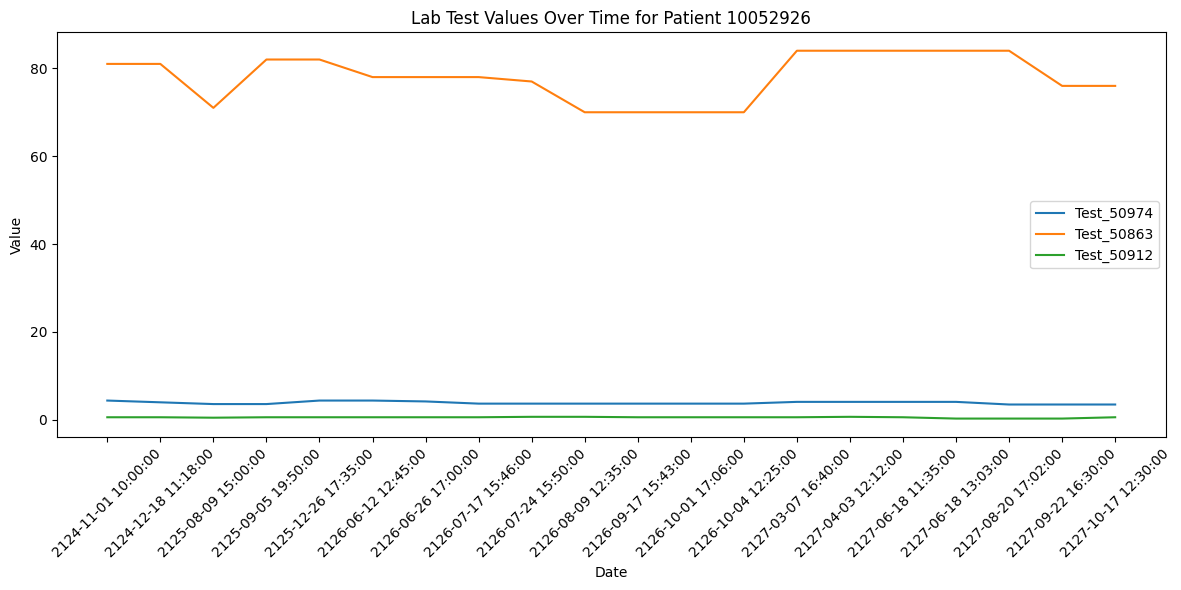

In [26]:
# Example of how the data looks for one patient
if len(patient_sequences) > 0:
    example_patient = list(patient_sequences.keys())[6]
    example_sequence = patient_sequences[example_patient]

    print(f"\nExample for patient {example_patient}:")
    print(f"Sequence shape: {example_sequence['sequences'].shape}")
    print(f"First few timestamps: {example_sequence['timestamps'][:3]}")
    print(f"Feature names: {example_sequence['feature_names']}")

    # Plot the sequences for this patient
    plt.figure(figsize=(12, 6))
    for i, feature_name in enumerate(example_sequence['feature_names']):
        plt.plot(example_sequence['timestamps'],
                 example_sequence['sequences'][:, i],
                 label=feature_name)

    plt.title(f"Lab Test Values Over Time for Patient {example_patient}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [27]:
# First, convert your patient_sequences dictionary to a DataFrame for easier merging
sequence_features = []
for subject_id, sequence_data in patient_sequences.items():
    # Extract key features from each sequence
    seq_features = {
        'subject_id': subject_id,
        'num_timepoints': len(sequence_data['timestamps']),
        'sequence_duration_days': (sequence_data['timestamps'][-1] - sequence_data['timestamps'][0]).total_seconds() / (24*3600),
        'latest_psa': sequence_data['sequences'][-1, 0],  # Last PSA value (assuming it's the first feature)
        'latest_alp': sequence_data['sequences'][-1, 1],  # Last ALP value
        'latest_creatinine': sequence_data['sequences'][-1, 2],  # Last Creatinine value
        'max_psa': np.max(sequence_data['sequences'][:, 0]),
        'max_alp': np.max(sequence_data['sequences'][:, 1]),
        'max_creatinine': np.max(sequence_data['sequences'][:, 2]),
        'psa_slope': np.polyfit(range(len(sequence_data['sequences'][:, 0])),
                               sequence_data['sequences'][:, 0], 1)[0]  # Linear trend
    }

    # Add the full sequence data as numpy arrays
    seq_features['full_sequence_data'] = sequence_data['sequences']
    seq_features['timestamps'] = sequence_data['timestamps']

    sequence_features.append(seq_features)

# Convert to DataFrame
sequence_df = pd.DataFrame(sequence_features)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
sequence_df.head()

,subject_id,num_timepoints,sequence_duration_days,latest_psa,latest_alp,latest_creatinine,max_psa,max_alp,max_creatinine,psa_slope,full_sequence_data,timestamps
0,10006716,20,528.099306,0.16,104.0,0.8,0.16,142.0,1.0,4.285714e-04,"[[0.11, 59.0, 0.9], [0.11, 59.0, 1.0], [0.11, ...","[2191-11-06 11:00:00, 2191-11-07 08:58:00, 219..."
1,10014610,20,1069.768056,3.10,130.0,1.1,6.00,130.0,1.6,3.345865e-02,"[[3.4, 130.0, 1.3], [3.4, 130.0, 1.2], [3.4, 1...","[2176-01-27 17:04:00, 2176-02-23 14:42:00, 217..."
2,10024331,20,197.913194,0.10,89.0,0.9,0.10,107.0,1.4,-2.402778e-18,"[[0.1, 107.0, 1.4], [0.1, 107.0, 1.4], [0.1, 1...","[2144-02-27 09:20:00, 2144-02-28 06:20:00, 214..."
3,10046298,20,1412.920139,6.10,27.0,1.1,6.10,47.0,1.3,3.827068e-02,"[[3.8, 35.0, 1.2], [3.6, 35.0, 1.2], [6.0, 31....","[2193-03-28 15:55:00, 2193-10-23 14:06:00, 219..."
4,10048001,20,5.414583,0.50,297.0,3.0,0.50,297.0,6.1,-1.251623e-17,"[[0.5, 159.0, 3.9], [0.5, 158.0, 4.6], [0.5, 1...","[2184-06-22 18:50:00, 2184-06-23 02:44:00, 218..."


In [29]:
# First create the target variables in pc_admissions
pc_admissions = pc_admissions.copy()  # Make a copy to avoid SettingWithCopyWarning

# 1. Mortality
pc_admissions['mortality'] = (~pd.isna(pc_admissions['deathtime'])).astype(int)

# 2. Length of Stay
pc_admissions['admittime'] = pd.to_datetime(pc_admissions['admittime'])
pc_admissions['dischtime'] = pd.to_datetime(pc_admissions['dischtime'])
pc_admissions['los_days'] = (pc_admissions['dischtime'] - pc_admissions['admittime']).dt.total_seconds() / (24 * 60 * 60)

# 3. Readmission
pc_admissions = pc_admissions.sort_values(['subject_id', 'admittime'])
pc_admissions['next_admit'] = pc_admissions.groupby('subject_id')['admittime'].shift(-1)
pc_admissions['days_to_readmit'] = (pd.to_datetime(pc_admissions['next_admit']) -
                                   pc_admissions['dischtime']).dt.total_seconds() / (24 * 60 * 60)
pc_admissions['readmission_30d'] = (pc_admissions['days_to_readmit'] <= 30).astype(int)

# Now we can check what we have
print("\nTarget Variables Summary:")
print("\nMortality rates:")
print(pc_admissions['mortality'].value_counts(normalize=True))

print("\nLength of stay statistics:")
print(pc_admissions['los_days'].describe())

print("\n30-day readmission rates:")
print(pc_admissions['readmission_30d'].value_counts(normalize=True))

# Now try the merge
patient_features = pc_patients.merge(
    pc_admissions[['subject_id', 'mortality', 'los_days', 'readmission_30d']],
    on='subject_id',
    how='left'
)

print("\nFinal dataset shape:", patient_features.shape)
print("\nColumns in final dataset:", patient_features.columns.tolist())


Target Variables Summary:

Mortality rates:
mortality
0    0.975599
1    0.024401
Name: proportion, dtype: float64

Length of stay statistics:
count    9344.000000
mean        4.926475
std         6.916112
min        -0.576389
25%         1.423437
50%         2.962500
75%         5.917361
max       134.682639
Name: los_days, dtype: float64

30-day readmission rates:
readmission_30d
0    0.774722
1    0.225278
Name: proportion, dtype: float64

Final dataset shape: (9344, 9)

Columns in final dataset: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'mortality', 'los_days', 'readmission_30d']


In [30]:
# Check number of unique patients
unique_patients = patient_features['subject_id'].nunique()  # Assuming you have a patient ID column
total_records = len(patient_features)

print(f"Total records: {total_records}")
print(f"Unique patients: {unique_patients}")

Total records: 9344
Unique patients: 2497


In [31]:
# First, fix the sympy issue
!pip install -U sympy transformers

# Then restart the kernel and try again with a simplified approach
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm

# Load ClinicalBERT
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Process notes in smaller batches with simplified error handling
def get_note_embeddings(texts, batch_size=8):
    """Process texts and return embeddings"""
    if not isinstance(texts, list):
        texts = [texts]

    all_embeddings = []

    # Process in batches to avoid memory issues
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        try:
            # Tokenize and get embeddings
            inputs = tokenizer(batch, padding=True, truncation=True,
                             max_length=512, return_tensors="pt").to(device)

            # Disable gradient calculation for inference
            with torch.no_grad():
                outputs = model(**inputs)

            # Get the [CLS] token embedding for each sequence
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(batch_embeddings)

        except Exception as e:
            print(f"Error processing batch: {e}")
            # Return zeros for failed batches
            batch_embeddings = np.zeros((len(batch), model.config.hidden_size))
            all_embeddings.append(batch_embeddings)

    # Combine all batch results
    if all_embeddings:
        return np.vstack(all_embeddings)
    else:
        return np.zeros((len(texts), model.config.hidden_size))

# Alternative approach: Use mean pooling instead of just CLS token
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Process discharge notes
print("Processing discharge notes...")
discharge_features = []

# Group by patient to handle multiple notes per patient
for subject_id, group in tqdm(discharge_prostate.groupby('subject_id')):
    try:
        # Get all notes for this patient
        texts = group['clean_text'].tolist()

        # Get embeddings for all notes
        embeddings = get_note_embeddings(texts)

        # Average the embeddings if there are multiple notes
        avg_embedding = np.mean(embeddings, axis=0)

        discharge_features.append({
            'subject_id': subject_id,
            'discharge_embedding': avg_embedding
        })
    except Exception as e:
        print(f"Error processing patient {subject_id}: {e}")
        # Add zeros for failed patients
        discharge_features.append({
            'subject_id': subject_id,
            'discharge_embedding': np.zeros(model.config.hidden_size)
        })

# Process radiology notes similarly
print("\nProcessing radiology notes...")
radiology_features = []

for subject_id, group in tqdm(radiology_prostate.groupby('subject_id')):
    try:
        texts = group['clean_text'].tolist()
        embeddings = get_note_embeddings(texts)
        avg_embedding = np.mean(embeddings, axis=0)

        radiology_features.append({
            'subject_id': subject_id,
            'radiology_embedding': avg_embedding
        })
    except Exception as e:
        print(f"Error processing patient {subject_id}: {e}")
        radiology_features.append({
            'subject_id': subject_id,
            'radiology_embedding': np.zeros(model.config.hidden_size)
        })

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Processing discharge notes...


  0%|          | 0/1969 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

100%|██████████| 1969/1969 [01:12<00:00, 27.16it/s]



Processing radiology notes...


 21%|██        | 427/2017 [00:49<03:05,  8.57it/s]


KeyboardInterrupt: 

In [ ]:
# First, use the sequence data as your foundation
# This ensures you're building around patients with sufficient temporal lab data
base_patients = sequence_df.copy()
print(f"Base patient set: {len(base_patients)} patients with sequential lab data")


Base patient set: 1267 patients with sequential lab data


In [ ]:
# First, let's check what columns are actually in patient_features
print("Columns in patient_features:", patient_features.columns.tolist())

# Let's try to find an appropriate time column for sorting
# It might be called something different like 'admission_time' or 'admit_dt'
time_columns = [col for col in patient_features.columns if 'time' in col.lower() or 'date' in col.lower()]
print("Potential time columns:", time_columns)


Columns in patient_features: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'mortality', 'los_days', 'readmission_30d']
Potential time columns: []


In [ ]:

# If you have pc_admissions dataframe, we can use that instead
# Assuming pc_admissions has the time fields we need
if 'pc_admissions' in globals():
    print("Using pc_admissions for time-based information")
    latest_admissions = pc_admissions.sort_values(['subject_id', 'admittime']).groupby('subject_id').last().reset_index()

    # Get key fields from latest admissions
    key_admission_fields = ['subject_id', 'mortality', 'los_days', 'readmission_30d']
    latest_admission_info = latest_admissions[key_admission_fields]

    # Now merge with base patients
    patient_with_demographics = base_patients.merge(
        latest_admission_info,
        on='subject_id',
        how='left'
    )
else:
    # If we don't have admissions data with timestamps, just use patient_features as is
    print("No admission timestamps found, using patient_features directly")
    patient_with_demographics = base_patients.merge(
        patient_features,
        on='subject_id',
        how='left'
    )

print(f"After adding demographics: {len(patient_with_demographics)} patients")

Using pc_admissions for time-based information
After adding demographics: 1267 patients


In [ ]:
# Add discharge note embeddings
discharge_df = pd.DataFrame(discharge_features)
# Convert the embedding array to individual columns
for i in range(len(discharge_df.iloc[0]['discharge_embedding'])):
    discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
discharge_df = discharge_df.drop(columns=['discharge_embedding'])

patient_with_notes = patient_with_demographics.merge(
    discharge_df,
    on='subject_id',
    how='left'
)

<ipython-input-46-4d8c12ec154b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-46-4d8c12ec154b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-46-4d8c12ec154b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [ ]:
# Add radiology note embeddings
radiology_df = pd.DataFrame(radiology_features)
# Convert the embedding array to individual columns
for i in range(len(radiology_df.iloc[0]['radiology_embedding'])):
    radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
radiology_df = radiology_df.drop(columns=['radiology_embedding'])

digital_twin_data = patient_with_notes.merge(
    radiology_df,
    on='subject_id',
    how='left'
)


<ipython-input-47-defb78e6064b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-47-defb78e6064b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-47-defb78e6064b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [ ]:
# Create a more descriptive digital twin ID
digital_twin_data['digital_twin_id'] = 'DT_' + digital_twin_data['subject_id'].astype(str)


In [ ]:
digital_twin_data.head()

,subject_id,num_timepoints,sequence_duration_days,latest_psa,latest_alp,latest_creatinine,max_psa,max_alp,max_creatinine,psa_slope,...,radiology_emb_759,radiology_emb_760,radiology_emb_761,radiology_emb_762,radiology_emb_763,radiology_emb_764,radiology_emb_765,radiology_emb_766,radiology_emb_767,digital_twin_id
0,10006716,20,528.099306,0.16,104.0,0.8,0.16,142.0,1.0,4.285714e-04,...,0.149311,-0.042689,0.087011,-0.000859,0.153153,0.149651,-0.025464,0.079235,0.014397,DT_10006716
1,10014610,20,1069.768056,3.10,130.0,1.1,6.00,130.0,1.6,3.345865e-02,...,0.131349,-0.120614,0.058973,-0.092351,0.318492,0.100476,-0.142692,0.229557,0.112722,DT_10014610
2,10024331,20,197.913194,0.10,89.0,0.9,0.10,107.0,1.4,-2.402778e-18,...,0.094238,-0.082766,0.044767,-0.110831,0.301044,0.076477,-0.224867,0.246564,0.100881,DT_10024331
3,10046298,20,1412.920139,6.10,27.0,1.1,6.10,47.0,1.3,3.827068e-02,...,0.049684,-0.004194,0.008327,-0.082326,0.160196,0.094526,-0.092432,0.149856,0.142914,DT_10046298
4,10048001,20,5.414583,0.50,297.0,3.0,0.50,297.0,6.1,-1.251623e-17,...,0.103973,-0.144072,0.097505,-0.034075,0.305868,0.156104,-0.161314,0.143069,0.095108,DT_10048001


In [ ]:
# Handle missing values
# Fill missing embeddings with zeros
embedding_cols = [col for col in digital_twin_data.columns if 'emb_' in col]
digital_twin_data[embedding_cols] = digital_twin_data[embedding_cols].fillna(0)

In [ ]:
# Fill other missing numeric values with median
numeric_cols = digital_twin_data.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in embedding_cols]
digital_twin_data[numeric_cols] = digital_twin_data[numeric_cols].fillna(digital_twin_data[numeric_cols].median())


In [ ]:
# Save the digital twin dataset
digital_twin_data.to_csv("/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data.csv", index=False)

print(f"Successfully created digital twin data for {len(digital_twin_data)} patients")


Successfully created digital twin data for 1267 patients


In [32]:
from os import read
#Load the saved dataset
# Save the digital twin dataset
digital_twin_data = pd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data.csv")


print(f"Loaded the previously saved digital_twin_dataset containting {len(digital_twin_data)} patients")


Loaded the previously saved digital_twin_dataset containting 1267 patients


In [33]:
# 1. Prepare the data

# Check what we have
print("Final dataset shape:", digital_twin_data.shape)
print("Columns:", digital_twin_data.columns.tolist())

# Check for missing values
missing_values = digital_twin_data.isnull().sum()
print("\nMissing values:")
print(missing_values[missing_values > 0])


Final dataset shape: (1267, 1552)
Columns: ['subject_id', 'num_timepoints', 'sequence_duration_days', 'latest_psa', 'latest_alp', 'latest_creatinine', 'max_psa', 'max_alp', 'max_creatinine', 'psa_slope', 'full_sequence_data', 'timestamps', 'mortality', 'los_days', 'readmission_30d', 'discharge_emb_0', 'discharge_emb_1', 'discharge_emb_2', 'discharge_emb_3', 'discharge_emb_4', 'discharge_emb_5', 'discharge_emb_6', 'discharge_emb_7', 'discharge_emb_8', 'discharge_emb_9', 'discharge_emb_10', 'discharge_emb_11', 'discharge_emb_12', 'discharge_emb_13', 'discharge_emb_14', 'discharge_emb_15', 'discharge_emb_16', 'discharge_emb_17', 'discharge_emb_18', 'discharge_emb_19', 'discharge_emb_20', 'discharge_emb_21', 'discharge_emb_22', 'discharge_emb_23', 'discharge_emb_24', 'discharge_emb_25', 'discharge_emb_26', 'discharge_emb_27', 'discharge_emb_28', 'discharge_emb_29', 'discharge_emb_30', 'discharge_emb_31', 'discharge_emb_32', 'discharge_emb_33', 'discharge_emb_34', 'discharge_emb_35', 'disch

In [34]:
# Handle missing values for numerical columns
numerical_cols = digital_twin_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if digital_twin_data[col].isnull().sum() > 0:
        digital_twin_data[col] = digital_twin_data[col].fillna(digital_twin_data[col].median())


In [35]:
# Get lab data for sequence features (assuming pc_relevant_labs contains your lab data)
pc_relevant_labs = pd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/pc_relevant_labs.csv")
lab_data = pc_relevant_labs

In [36]:
# Split features and targets
targets = ['mortality', 'los_days', 'readmission_30d']
X = digital_twin_data.drop(targets, axis=1)
y = digital_twin_data[targets]


In [37]:
# Split data
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['mortality']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval['mortality']
)

print("\nData split sizes:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")



Data split sizes:
Train: 810 samples
Validation: 203 samples
Test: 254 samples


In [39]:
# Function to convert individual embedding columns back to arrays
def convert_embeddings_to_arrays(df):
    """Convert individual embedding columns into single array columns"""
    print("Converting embeddings to arrays...")

    # Create a copy of the dataframe
    result_df = df.copy()

    # Get embedding column names
    discharge_cols = [col for col in df.columns if 'discharge_emb_' in col]
    radiology_cols = [col for col in df.columns if 'radiology_emb_' in col]

    print(f"Found {len(discharge_cols)} discharge embedding columns")
    print(f"Found {len(radiology_cols)} radiology embedding columns")

    # Create embedding arrays
    discharge_embeddings = []
    radiology_embeddings = []

    # Process each row
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # Extract discharge embeddings
        if discharge_cols:
            discharge_emb = row[discharge_cols].values.astype(np.float32)
            discharge_embeddings.append(discharge_emb)
        else:
            discharge_embeddings.append(np.zeros(768, dtype=np.float32))

        # Extract radiology embeddings
        if radiology_cols:
            radiology_emb = row[radiology_cols].values.astype(np.float32)
            radiology_embeddings.append(radiology_emb)
        else:
            radiology_embeddings.append(np.zeros(768, dtype=np.float32))

    # Add the arrays to the dataframe
    result_df['discharge_embedding'] = discharge_embeddings
    result_df['radiology_embedding'] = radiology_embeddings

    # Drop the individual columns
    result_df = result_df.drop(columns=discharge_cols + radiology_cols)

    return result_df

# Apply the conversion to our datasets
X_train_arrays = convert_embeddings_to_arrays(X_train)
X_val_arrays = convert_embeddings_to_arrays(X_val)
X_test_arrays = convert_embeddings_to_arrays(X_test)

# Now create the dataset with the original EnhancedPCDataset class
try:
    print("\nCreating sample dataset with array embeddings...")
    sample_dataset = EnhancedPCDataset(X_train_arrays.iloc[:5], y_train.iloc[:5], lab_data)
    print("Sample dataset created successfully!")

    # Check what's in a sample batch
    sample_item = sample_dataset[0]
    for key, value in sample_item.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: Tensor of shape {value.shape}, dtype {value.dtype}")
        else:
            print(f"{key}: {type(value)}")

except Exception as e:
    print(f"Error creating dataset: {e}")

    # Print debugging information
    print("\nChecking input data:")
    print("X_train_arrays columns:", X_train_arrays.columns.tolist())
    print("Sample discharge_embedding type:", type(X_train_arrays['discharge_embedding'].iloc[0]))

Converting embeddings to arrays...
Found 768 discharge embedding columns
Found 768 radiology embedding columns


100%|██████████| 810/810 [00:01<00:00, 629.18it/s]


Converting embeddings to arrays...
Found 768 discharge embedding columns
Found 768 radiology embedding columns


100%|██████████| 203/203 [00:00<00:00, 632.21it/s]


Converting embeddings to arrays...
Found 768 discharge embedding columns
Found 768 radiology embedding columns


100%|██████████| 254/254 [00:00<00:00, 628.95it/s]


Creating sample dataset with array embeddings...
Processing embeddings...
Engineering features...
Error creating dataset: could not convert string to float: '[[7.0e-02 8.0e+01 1.0e+00]\n [7.0e-02 7.7e+01 1.2e+00]\n [7.0e-02 8.0e+01 1.1e+00]\n [8.0e-02 7.7e+01 1.1e+00]\n [1.0e-01 7.7e+01 1.0e+00]\n [1.3e-01 8.1e+01 1.2e+00]\n [1.3e-01 7.9e+01 9.0e-01]\n [1.4e-01 7.8e+01 9.0e-01]\n [1.4e-01 7.8e+01 9.0e-01]\n [1.6e-01 6.7e+01 1.1e+00]\n [2.2e-01 6.7e+01 1.1e+00]\n [2.8e-01 6.0e+01 1.0e+00]\n [2.8e-01 5.7e+01 1.2e+00]\n [2.8e-01 4.3e+01 1.0e+00]\n [2.8e-01 4.4e+01 8.0e-01]\n [4.0e-01 7.4e+01 1.0e+00]\n [4.0e-01 6.9e+01 1.2e+00]\n [3.0e-01 7.0e+01 1.0e+00]\n [3.0e-01 7.3e+01 9.0e-01]\n [3.0e-01 7.2e+01 1.0e+00]]'

Checking input data:
X_train_arrays columns: ['subject_id', 'num_timepoints', 'sequence_duration_days', 'latest_psa', 'latest_alp', 'latest_creatinine', 'max_psa', 'max_alp', 'max_creatinine', 'psa_slope', 'full_sequence_data', 'timestamps', 'digital_twin_id', 'discharge_embeddi

In [40]:
# Complete implementation of ModifiedPCDataset
class ModifiedPCDataset(Dataset):
    def __init__(self, X, y, lab_data):
        self.X = X
        self.y = y
        self.lab_data = lab_data

        # Identify embedding columns
        self.discharge_cols = [col for col in X.columns if 'discharge_emb_' in col]
        self.radiology_cols = [col for col in X.columns if 'radiology_emb_' in col]

        print(f"Using {len(self.discharge_cols)} discharge columns and {len(self.radiology_cols)} radiology columns")

        # Get basic feature columns (excluding embedding columns and non-numeric columns)
        self.feature_cols = []
        for col in X.columns:
            if (col != 'subject_id' and
                'discharge_emb_' not in col and
                'radiology_emb_' not in col):
                # Check if column is numeric
                try:
                    # Try converting a sample to float
                    float(X[col].iloc[0])
                    self.feature_cols.append(col)
                except (ValueError, TypeError):
                    print(f"Skipping non-numeric column: {col}")

        print(f"Using {len(self.feature_cols)} numeric feature columns")

        # Process structured features
        self.process_structured_features()

        # Process time-series data
        self.timeseries_data = []
        self.process_timeseries()

    def process_structured_features(self):
        """Process and engineer structured features"""
        print("Engineering features...")
        # Convert numeric features to numpy array
        self.structured_features = self.X[self.feature_cols].values.astype(np.float32)

        # Add engineered features
        engineered_features = []
        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]

            # Get available patient data
            patient_data = {'subject_id': patient_id}
            if 'anchor_age' in self.feature_cols:
                patient_data['anchor_age'] = self.X['anchor_age'].iloc[i]
            else:
                patient_data['anchor_age'] = 0  # Default value

            # Get this patient's lab data
            patient_labs = self.lab_data[self.lab_data['subject_id'] == patient_id]

            # Engineer features
            features = self.engineer_features(patient_data, patient_labs)
            engineered_features.append(list(features.values()))

        # Convert to numpy array
        if engineered_features:
            engineered_array = np.array(engineered_features, dtype=np.float32)
            # Combine with standard features
            self.structured_features = np.hstack([self.structured_features, engineered_array])

    def process_timeseries(self):
        """Prepare time-series data for each patient"""
        print("Processing time-series data...")
        max_seq_length = 20

        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            ts_data = self.prepare_timeseries_data(patient_id, self.lab_data, max_seq_length)
            self.timeseries_data.append(ts_data)

    def engineer_features(self, patient_data, lab_data):
        """Create advanced features from patient data"""
        features = {}

        # 1. PSA-specific features
        psa_values = lab_data[(lab_data['itemid'] == 50974)]['valuenum'].values

        if len(psa_values) >= 2:
            # PSA velocity (rate of change per year)
            features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

            # PSA doubling time
            if psa_values[0] > 0 and psa_values[-1] > 0:
                features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
            else:
                features['psa_doubling_time'] = 0

            # PSA variability
            features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
        else:
            features['psa_velocity'] = 0
            features['psa_doubling_time'] = 0
            features['psa_variability'] = 0

        # 2. Age-related features
        features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

        # 3. Comorbidity features (count of other diagnoses)
        diagnoses_count = len(lab_data['itemid'].unique())
        features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

        # 4. Lab test frequency features
        test_frequency = lab_data.groupby('itemid').size()
        features['lab_test_frequency'] = len(test_frequency)

        # 5. Treatment indicators
        has_hormone_therapy = any(test_id in lab_data['itemid'].values
                                for test_id in [50988, 50894])  # Testosterone tests
        features['hormone_therapy'] = int(has_hormone_therapy)

        return features

    def prepare_timeseries_data(self, patient_id, lab_data, max_seq_length=20):
        """Create time-ordered sequences of lab values for a patient"""
        # Filter data for this patient
        patient_labs = lab_data[lab_data['subject_id'] == patient_id]

        # Sort by time
        if 'charttime' in patient_labs.columns:
            patient_labs = patient_labs.sort_values('charttime')

        # Create sequences for key lab tests
        key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

        # Initialize sequences
        sequences = []

        for test_id in key_tests:
            test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
            # Pad or truncate to fixed length
            if len(test_values) > max_seq_length:
                test_values = test_values[-max_seq_length:]  # Keep most recent
            elif len(test_values) < max_seq_length:
                test_values = np.pad(test_values,
                                    (0, max_seq_length - len(test_values)),
                                    'constant',
                                    constant_values=0)
            sequences.append(test_values)

        # Stack all tests
        if sequences:
            return np.stack(sequences, axis=1)  # [seq_length, num_features]
        else:
            return np.zeros((max_seq_length, len(key_tests)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features (including engineered features)
        structured = torch.tensor(self.structured_features[idx], dtype=torch.float32)

        # Get discharge embeddings
        if self.discharge_cols:
            try:
                # First convert each value to float
                emb_values = [float(self.X.iloc[idx][col]) for col in self.discharge_cols]
                discharge_emb = torch.tensor(emb_values, dtype=torch.float32)
            except (ValueError, TypeError):
                print(f"Warning: Could not convert discharge embeddings for idx {idx}")
                discharge_emb = torch.zeros(len(self.discharge_cols), dtype=torch.float32)
        else:
            discharge_emb = torch.zeros(768, dtype=torch.float32)

        # Get radiology embeddings
        if self.radiology_cols:
            try:
                # First convert each value to float
                emb_values = [float(self.X.iloc[idx][col]) for col in self.radiology_cols]
                radiology_emb = torch.tensor(emb_values, dtype=torch.float32)
            except (ValueError, TypeError):
                print(f"Warning: Could not convert radiology embeddings for idx {idx}")
                radiology_emb = torch.zeros(len(self.radiology_cols), dtype=torch.float32)
        else:
            radiology_emb = torch.zeros(768, dtype=torch.float32)

        # Get time-series data
        timeseries = torch.tensor(self.timeseries_data[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'structured': structured,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'timeseries': timeseries,
            'labels': labels
        }

In [41]:
# Create datasets using the modified class that works with individual columns
try:
    # Create a small test dataset first
    print("\nCreating small test dataset...")
    test_small_dataset = ModifiedPCDataset(X_train.iloc[:10], y_train.iloc[:10], lab_data)
    print("Small test dataset created successfully!")

    # Check sample item
    sample_item = test_small_dataset[0]
    for key, value in sample_item.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: Tensor of shape {value.shape}, dtype {value.dtype}")
        else:
            print(f"{key}: {type(value)}")

    # If small test works, create full datasets
    print("\nCreating full datasets...")
    train_dataset = ModifiedPCDataset(X_train, y_train, lab_data)
    val_dataset = ModifiedPCDataset(X_val, y_val, lab_data)
    test_dataset = ModifiedPCDataset(X_test, y_test, lab_data)

    print(f"Created datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

except Exception as e:
    print(f"Error creating dataset: {e}")
    import traceback
    traceback.print_exc()


Creating small test dataset...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Skipping non-numeric column: digital_twin_id
Using 9 numeric feature columns
Engineering features...
Processing time-series data...
Small test dataset created successfully!
structured: Tensor of shape torch.Size([16]), dtype torch.float32
discharge_emb: Tensor of shape torch.Size([768]), dtype torch.float32
radiology_emb: Tensor of shape torch.Size([768]), dtype torch.float32
timeseries: Tensor of shape torch.Size([20, 4]), dtype torch.float32
labels: Tensor of shape torch.Size([3]), dtype torch.float32

Creating full datasets...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Skipping non-numeric column: digital_twin_id
Using 9 numeric feature columns
Engineering features...
Processing time-series data...
Using 768 discha

In [42]:
# Create data loaders
from torch.utils.data import DataLoader

batch_size = 16  # Start with a small batch size for testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [43]:

# Define the digital twin model
import torch.nn as nn
import torch.nn.functional as F

class DigitalTwinModel(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, ts_seq_len=20, ts_features=4, hidden_dim=64):
        super(DigitalTwinModel, self).__init__()

        # Process structured data
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process discharge notes
        self.discharge_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process radiology notes
        self.radiology_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time series with LSTM
        self.ts_encoder = nn.LSTM(
            input_size=ts_features,
            hidden_size=hidden_dim,
            batch_first=True
        )

        # Combine features
        combined_dim = hidden_dim * 4  # structured + discharge + radiology + ts

        # Output heads
        self.mortality_head = nn.Sequential(
            nn.Linear(combined_dim, 1),
            nn.Sigmoid()
        )

        self.los_head = nn.Linear(combined_dim, 1)

        self.readmission_head = nn.Sequential(
            nn.Linear(combined_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Process each data type
        structured_features = self.structured_encoder(structured)
        discharge_features = self.discharge_encoder(discharge_emb)
        radiology_features = self.radiology_encoder(radiology_emb)

        # Process time series
        ts_output, (hidden, _) = self.ts_encoder(timeseries)
        ts_features = hidden.squeeze(0)

        # Combine all features
        combined = torch.cat((
            structured_features,
            discharge_features,
            radiology_features,
            ts_features
        ), dim=1)

        # Get predictions
        mortality = self.mortality_head(combined)
        los = self.los_head(combined)
        readmission = self.readmission_head(combined)

        return mortality, los, readmission



In [44]:
# Get the dimension of structured features
sample_batch = next(iter(train_loader))
structured_dim = sample_batch['structured'].shape[1]
print(f"Structured feature dimension: {structured_dim}")


Structured feature dimension: 16


In [45]:
# Get the dimension of structured features
sample_batch = next(iter(train_loader))
structured_dim = sample_batch['structured'].shape[1]
print(f"Structured feature dimension: {structured_dim}")

# Create and test the model
try:
    # Create model
    model = DigitalTwinModel(structured_dim=structured_dim)
    print("Model created successfully")

    # Test with a single batch
    structured = sample_batch['structured']
    discharge_emb = sample_batch['discharge_emb']
    radiology_emb = sample_batch['radiology_emb']
    timeseries = sample_batch['timeseries']
    labels = sample_batch['labels']

    # Forward pass
    mortality_pred, los_pred, readmission_pred = model(
        structured, discharge_emb, radiology_emb, timeseries
    )

    print(f"Model outputs - Mortality: {mortality_pred.shape}, LOS: {los_pred.shape}, Readmission: {readmission_pred.shape}")

    # Calculate simple loss
    mortality_loss = F.binary_cross_entropy(mortality_pred, labels[:, 0:1])
    los_loss = F.mse_loss(los_pred, labels[:, 1:2])
    readmission_loss = F.binary_cross_entropy(readmission_pred, labels[:, 2:3])

    total_loss = mortality_loss + los_loss + readmission_loss
    print(f"Loss calculation successful - Total loss: {total_loss.item():.4f}")

except Exception as e:
    print(f"Error testing model: {e}")
    import traceback
    traceback.print_exc()

Structured feature dimension: 16
Model created successfully
Model outputs - Mortality: torch.Size([16, 1]), LOS: torch.Size([16, 1]), Readmission: torch.Size([16, 1])
Loss calculation successful - Total loss: 33282.9336


In [46]:
# Define training function
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define loss functions
    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Track metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Calculate losses
            mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
            los_loss = mse_loss(los_pred, labels[:, 1:2])
            readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

            # Combined loss - weighted sum
            loss = 0.4 * mortality_loss + 0.3 * los_loss / 100 + 0.3 * readmission_loss  # Scale down LOS loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                # Move data to device
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                mortality_pred, los_pred, readmission_pred = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Calculate losses
                mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
                los_loss = mse_loss(los_pred, labels[:, 1:2])
                readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

                # Combined loss
                loss = 0.4 * mortality_loss + 0.3 * los_loss / 100 + 0.3 * readmission_loss

                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Update scheduler
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'digital_twin_best_model.pt')
            print(f"Epoch {epoch+1}: Saved new best model with val_loss: {val_loss:.4f}")

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best model
    model.load_state_dict(torch.load('digital_twin_best_model.pt'))

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history.png')
    plt.show()

    return model, train_losses, val_losses

# Create the model
model = DigitalTwinModel(structured_dim=structured_dim)

# Train the model (set epochs to a higher value for better results)
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, epochs=15, lr=0.001
)

Using device: cuda


KeyboardInterrupt: 

In [ ]:
# Define evaluation function
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Initialize prediction and target containers
    all_mortality_preds = []
    all_los_preds = []
    all_readmission_preds = []
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Collect predictions
            all_mortality_preds.extend(mortality_pred.cpu().numpy())
            all_los_preds.extend(los_pred.cpu().numpy())
            all_readmission_preds.extend(readmission_pred.cpu().numpy())
            all_true_labels.extend(batch['labels'].numpy())

    # Convert to numpy arrays
    all_mortality_preds = np.array(all_mortality_preds)
    all_los_preds = np.array(all_los_preds)
    all_readmission_preds = np.array(all_readmission_preds)
    all_true_labels = np.array(all_true_labels)

    # Calculate metrics
    from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score, precision_recall_fscore_support

    # Mortality metrics
    mortality_auc = roc_auc_score(all_true_labels[:, 0], all_mortality_preds.squeeze())
    mortality_preds_binary = (all_mortality_preds > 0.5).astype(int)
    mortality_acc = accuracy_score(all_true_labels[:, 0], mortality_preds_binary.squeeze())

    # Length of stay metrics
    los_mse = mean_squared_error(all_true_labels[:, 1], all_los_preds.squeeze())
    los_rmse = np.sqrt(los_mse)

    # Readmission metrics
    readmission_auc = roc_auc_score(all_true_labels[:, 2], all_readmission_preds.squeeze())
    readmission_preds_binary = (all_readmission_preds > 0.5).astype(int)
    readmission_acc = accuracy_score(all_true_labels[:, 2], readmission_preds_binary.squeeze())

    # Print results
    print("Test Results:")
    print(f"Mortality - AUC: {mortality_auc:.4f}, Accuracy: {mortality_acc:.4f}")
    print(f"Length of Stay - MSE: {los_mse:.4f}, RMSE: {los_rmse:.4f}")
    print(f"Readmission - AUC: {readmission_auc:.4f}, Accuracy: {readmission_acc:.4f}")

    return {
        'mortality_auc': mortality_auc,
        'mortality_acc': mortality_acc,
        'los_mse': los_mse,
        'los_rmse': los_rmse,
        'readmission_auc': readmission_auc,
        'readmission_acc': readmission_acc
    }

# Evaluate the trained model
evaluation_results = evaluate_model(trained_model, test_loader)

Test Results:
Mortality - AUC: 0.6254, Accuracy: 0.8819
Length of Stay - MSE: 83.6171, RMSE: 9.1442
Readmission - AUC: nan, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
# same thing as above but with progress trackers
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Initialize prediction and target containers
    all_mortality_preds = []
    all_los_preds = []
    all_readmission_preds = []
    all_true_labels = []

    print(f"Evaluating model on {len(test_loader)} batches...")

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # Print progress every few batches
            if (i + 1) % 5 == 0:
                print(f"Processing batch {i+1}/{len(test_loader)}")

            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Collect predictions
            all_mortality_preds.extend(mortality_pred.cpu().numpy())
            all_los_preds.extend(los_pred.cpu().numpy())
            all_readmission_preds.extend(readmission_pred.cpu().numpy())
            all_true_labels.extend(batch['labels'].numpy())

    print("Computing metrics...")

    # Convert to numpy arrays
    all_mortality_preds = np.array(all_mortality_preds)
    all_los_preds = np.array(all_los_preds)
    all_readmission_preds = np.array(all_readmission_preds)
    all_true_labels = np.array(all_true_labels)

    # Calculate metrics
    from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score, precision_recall_fscore_support

    # Mortality metrics
    mortality_auc = roc_auc_score(all_true_labels[:, 0], all_mortality_preds.squeeze())
    mortality_preds_binary = (all_mortality_preds > 0.5).astype(int)
    mortality_acc = accuracy_score(all_true_labels[:, 0], mortality_preds_binary.squeeze())

    # Length of stay metrics
    los_mse = mean_squared_error(all_true_labels[:, 1], all_los_preds.squeeze())
    los_rmse = np.sqrt(los_mse)

    # Readmission metrics
    readmission_auc = roc_auc_score(all_true_labels[:, 2], all_readmission_preds.squeeze())
    readmission_preds_binary = (all_readmission_preds > 0.5).astype(int)
    readmission_acc = accuracy_score(all_true_labels[:, 2], readmission_preds_binary.squeeze())

    # Print results
    print("\nTest Results:")
    print(f"Mortality - AUC: {mortality_auc:.4f}, Accuracy: {mortality_acc:.4f}")
    print(f"Length of Stay - MSE: {los_mse:.4f}, RMSE: {los_rmse:.4f}")
    print(f"Readmission - AUC: {readmission_auc:.4f}, Accuracy: {readmission_acc:.4f}")

    return {
        'mortality_auc': mortality_auc,
        'mortality_acc': mortality_acc,
        'los_mse': los_mse,
        'los_rmse': los_rmse,
        'readmission_auc': readmission_auc,
        'readmission_acc': readmission_acc
    }

# Evaluate with progress updates
evaluation_results = evaluate_model(trained_model, test_loader)

In [ ]:
# Define a version of the model without temporal data (ablation)
class DigitalTwinNoTemporal(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, hidden_dim=64):
        super(DigitalTwinNoTemporal, self).__init__()

        # Process structured data
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process discharge notes
        self.discharge_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process radiology notes
        self.radiology_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Combine features
        combined_dim = hidden_dim * 3  # structured + discharge + radiology

        # Output heads
        self.mortality_head = nn.Sequential(
            nn.Linear(combined_dim, 1),
            nn.Sigmoid()
        )

        self.los_head = nn.Linear(combined_dim, 1)

        self.readmission_head = nn.Sequential(
            nn.Linear(combined_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, structured, discharge_emb, radiology_emb, _):  # Ignore timeseries
        # Process each data type
        structured_features = self.structured_encoder(structured)
        discharge_features = self.discharge_encoder(discharge_emb)
        radiology_features = self.radiology_encoder(radiology_emb)

        # Combine features (no temporal data)
        combined = torch.cat((
            structured_features,
            discharge_features,
            radiology_features
        ), dim=1)

        # Get predictions
        mortality = self.mortality_head(combined)
        los = self.los_head(combined)
        readmission = self.readmission_head(combined)

        return mortality, los, readmission




Training model without temporal data (ablation study)...
Using device: cuda
Epoch 1: Saved new best model with val_loss: 5.6516
Epoch 1/15 - Train Loss: 103.6801, Val Loss: 5.6516
Epoch 2/15 - Train Loss: 125.7751, Val Loss: 50.4116
Epoch 3: Saved new best model with val_loss: 2.8038
Epoch 3/15 - Train Loss: 42.8499, Val Loss: 2.8038
Epoch 4: Saved new best model with val_loss: 2.4960
Epoch 4/15 - Train Loss: 30.8752, Val Loss: 2.4960
Epoch 5/15 - Train Loss: 30.0583, Val Loss: 3.6937
Epoch 6/15 - Train Loss: 28.1599, Val Loss: 2.6368
Epoch 7/15 - Train Loss: 24.1783, Val Loss: 2.6261
Epoch 8: Saved new best model with val_loss: 2.3595
Epoch 8/15 - Train Loss: 14.6430, Val Loss: 2.3595
Epoch 9/15 - Train Loss: 12.1434, Val Loss: 3.9021
Epoch 10/15 - Train Loss: 11.8721, Val Loss: 2.3857
Epoch 11/15 - Train Loss: 10.6060, Val Loss: 3.0470
Epoch 12: Saved new best model with val_loss: 2.0683
Epoch 12/15 - Train Loss: 5.5148, Val Loss: 2.0683
Epoch 13/15 - Train Loss: 5.7419, Val Loss: 3

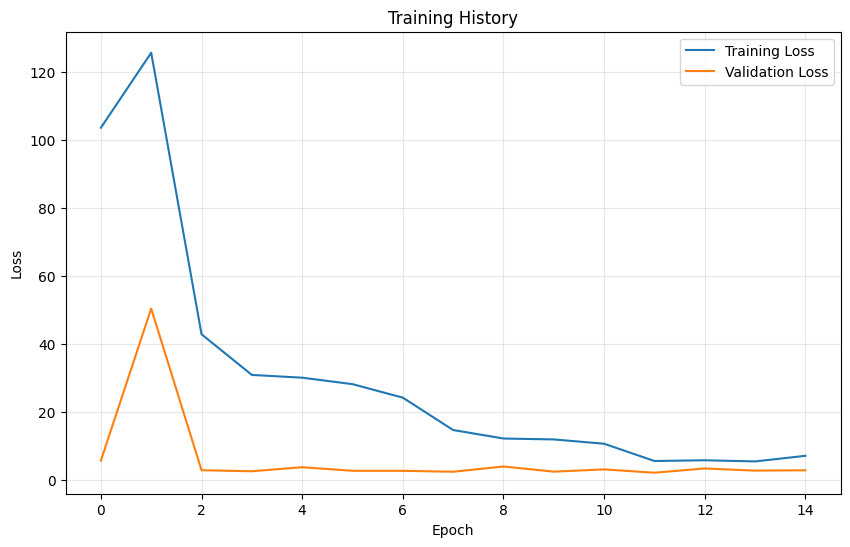

In [ ]:
# Create and train the model without temporal data
print("\nTraining model without temporal data (ablation study)...")
no_temporal_model = DigitalTwinNoTemporal(structured_dim=structured_dim)
no_temporal_trained, _, _ = train_model(
    no_temporal_model, train_loader, val_loader, epochs=15, lr=0.001
)



In [ ]:
# Evaluate the non-temporal model
no_temporal_results = evaluate_model(no_temporal_trained, test_loader)



Test Results:
Mortality - AUC: 0.5751, Accuracy: 0.8583
Length of Stay - MSE: 77.9416, RMSE: 8.8285
Readmission - AUC: nan, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
# Compare results
print("\nAblation Study Results:")
print("-" * 50)
print("                   | With Temporal Data | Without Temporal Data")
print("-" * 50)
print(f"Mortality AUC      | {evaluation_results['mortality_auc']:.4f} | {no_temporal_results['mortality_auc']:.4f}")
print(f"Mortality Accuracy | {evaluation_results['mortality_acc']:.4f} | {no_temporal_results['mortality_acc']:.4f}")
print(f"Length of Stay RMSE| {evaluation_results['los_rmse']:.4f} | {no_temporal_results['los_rmse']:.4f}")
if not np.isnan(evaluation_results['readmission_auc']) and not np.isnan(no_temporal_results['readmission_auc']):
    print(f"Readmission AUC    | {evaluation_results['readmission_auc']:.4f} | {no_temporal_results['readmission_auc']:.4f}")
print(f"Readmission Acc    | {evaluation_results['readmission_acc']:.4f} | {no_temporal_results['readmission_acc']:.4f}")
print("-" * 50)


Ablation Study Results:
--------------------------------------------------
                   | With Temporal Data | Without Temporal Data
--------------------------------------------------
Mortality AUC      | 0.6254 | 0.5751
Mortality Accuracy | 0.8819 | 0.8583
Length of Stay RMSE| 9.1442 | 8.8285
Readmission Acc    | 1.0000 | 1.0000
--------------------------------------------------


## Mixture of Experts

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Expert network definition
class ExpertNetwork(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, hidden_dim=64):
        super().__init__()
        # Process structured data
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process discharge notes
        self.discharge_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process radiology notes
        self.radiology_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time series with LSTM
        self.ts_encoder = nn.LSTM(
            input_size=4,  # PSA, Testosterone, ALP, Creatinine
            hidden_size=hidden_dim,
            batch_first=True
        )

        # Fusion layer
        self.fusion = nn.Linear(hidden_dim*4, hidden_dim)

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Process each data type
        structured_features = self.structured_encoder(structured)
        discharge_features = self.discharge_encoder(discharge_emb)
        radiology_features = self.radiology_encoder(radiology_emb)

        # Process time series
        _, (hidden, _) = self.ts_encoder(timeseries)
        ts_features = hidden.squeeze(0)

        # Combine features
        combined = torch.cat([
            structured_features,
            discharge_features,
            radiology_features,
            ts_features
        ], dim=1)

        return self.fusion(combined)

# Mixture of Experts model
class DigitalTwinMoE(nn.Module):
    def __init__(self, structured_dim, num_experts=4, embedding_dim=768, hidden_dim=64):
        super().__init__()

        # Create multiple expert networks
        self.experts = nn.ModuleList([
            ExpertNetwork(structured_dim, embedding_dim, hidden_dim)
            for _ in range(num_experts)
        ])

        # Gating network to determine expert weights
        self.gate = nn.Sequential(
            nn.Linear(structured_dim + embedding_dim*2, 128),
            nn.ReLU(),
            nn.Linear(128, num_experts),
            nn.Softmax(dim=1)
        )

        # Task-specific output heads
        self.mortality_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.los_head = nn.Linear(hidden_dim, 1)

        self.readmission_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Determine expert weights using gate
        gate_input = torch.cat([structured, discharge_emb, radiology_emb], dim=1)
        expert_weights = self.gate(gate_input)

        # Get outputs from each expert
        expert_outputs = []
        for expert in self.experts:
            expert_out = expert(structured, discharge_emb, radiology_emb, timeseries)
            expert_outputs.append(expert_out.unsqueeze(1))

        # Stack expert outputs
        stacked_outputs = torch.cat(expert_outputs, dim=1)  # [batch, num_experts, hidden_dim]

        # Weighted sum of expert outputs
        weighted_output = torch.bmm(
            expert_weights.unsqueeze(1),  # [batch, 1, num_experts]
            stacked_outputs  # [batch, num_experts, hidden_dim]
        ).squeeze(1)  # [batch, hidden_dim]

        # Get predictions from task heads
        mortality = self.mortality_head(weighted_output)
        los = self.los_head(weighted_output)
        readmission = self.readmission_head(weighted_output)

        return mortality, los, readmission, expert_weights




Initializing Mixture of Experts Digital Twin model...
Model created with 735047 parameters
Using 4 expert networks

Starting Mixture of Experts model training...
Using device: cuda
Using Adam optimizer with learning rate: 0.001

Starting training for 20 epochs...
Training on 810 samples, validating on 203 samples

Epoch 1/20
  Completed 51/51 training batches
  Training stats - Loss: 23.7928, Mortality: 0.4767, LOS: 7857.9692, Readmission: 0.1246, Diversity: -0.0091
  Validation stats - Loss: 2.5010, Mortality: 0.2370, LOS: 802.0588, Readmission: 0.0000
  Expert utilization: [1.94855811e-01 2.40149427e-04 4.24816203e-02 7.62422416e-01]
  New best model saved with val_loss: 2.5010

Epoch 2/20
  Completed 51/51 training batches
  Training stats - Loss: 3.2953, Mortality: 0.2857, LOS: 1058.0560, Readmission: 0.0256, Diversity: -0.0008
  Validation stats - Loss: 1.1126, Mortality: 0.2287, LOS: 340.3655, Readmission: 0.0000
  Expert utilization: [3.25803159e-01 1.65562673e-04 5.31770290e-0

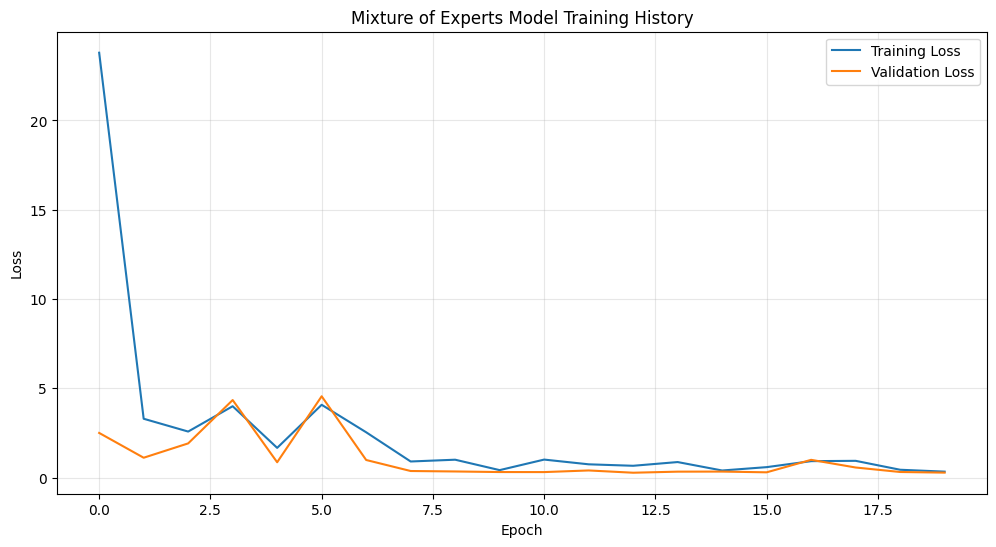

In [48]:

# Focal Loss implementation
def focal_loss(pred, target, alpha=0.25, gamma=2.0):
    """
    Focal Loss for dealing with class imbalance

    Args:
        pred: Model predictions (sigmoid already applied)
        target: Ground truth labels
        alpha: Weighting factor for the rare class
        gamma: Focusing parameter that reduces the loss contribution from easy examples
    """
    # Binary cross entropy
    bce = -(target * torch.log(pred + 1e-7) + (1 - target) * torch.log(1 - pred + 1e-7))

    # Apply the focusing term
    pt = torch.where(target == 1, pred, 1 - pred)
    focal_weight = alpha * (1 - pt) ** gamma

    # Apply the weights and take the mean
    loss = focal_weight * bce
    return loss.mean()


# To use this model:
# 1. Create the model with progress tracking
print("\nInitializing Mixture of Experts Digital Twin model...")
moe_model = DigitalTwinMoE(structured_dim=structured_dim, num_experts=4)
print(f"Model created with {sum(p.numel() for p in moe_model.parameters())} parameters")
print(f"Using {len(moe_model.experts)} expert networks")

# Modified training function with more detailed progress tracking
def train_moe_model_with_tracking(model, train_loader, val_loader, epochs=15, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"Using Adam optimizer with learning rate: {lr}")

    # Loss for length of stay
    mse_loss = nn.MSELoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Track metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print(f"\nStarting training for {epochs} epochs...")
    print(f"Training on {len(train_loader.dataset)} samples, validating on {len(val_loader.dataset)} samples")

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        mortality_losses = []
        los_losses = []
        readmission_losses = []
        diversity_losses = []

        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training loop with progress bar
        for batch_idx, batch in enumerate(train_loader):
            if batch_idx % 10 == 0:
                print(f"  Training batch {batch_idx+1}/{len(train_loader)}", end="\r")

            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with expert weights
            mortality_pred, los_pred, readmission_pred, expert_weights = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Calculate losses with focal loss for classification tasks
            m_loss = focal_loss(mortality_pred, labels[:, 0:1])
            l_loss = mse_loss(los_pred, labels[:, 1:2])
            r_loss = focal_loss(readmission_pred, labels[:, 2:3])
            mortality_losses.append(m_loss.item())
            los_losses.append(l_loss.item())
            readmission_losses.append(r_loss.item())

            # Expert diversity loss (encourage specialization)
            entropy = -(expert_weights * torch.log(expert_weights + 1e-7)).sum(dim=1).mean()
            d_loss = -0.1 * entropy  # Negative because we want to maximize entropy
            diversity_losses.append(d_loss.item())

            # Combined loss - weighted sum
            loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss + d_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Print batch completion
        print(f"  Completed {len(train_loader)}/{len(train_loader)} training batches")

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Print detailed training metrics
        print(f"  Training stats - Loss: {train_loss:.4f}, " +
              f"Mortality: {np.mean(mortality_losses):.4f}, " +
              f"LOS: {np.mean(los_losses):.4f}, " +
              f"Readmission: {np.mean(readmission_losses):.4f}, " +
              f"Diversity: {np.mean(diversity_losses):.4f}")

        # Validation
        model.eval()
        val_loss = 0
        val_mortality_losses = []
        val_los_losses = []
        val_readmission_losses = []
        expert_usage = np.zeros(len(model.experts))

        print("  Validating...", end="\r")
        with torch.no_grad():
            for batch in val_loader:
                # Move data to device
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                mortality_pred, los_pred, readmission_pred, expert_weights = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Track expert usage
                expert_usage += expert_weights.sum(dim=0).cpu().numpy()

                # Calculate losses
                m_loss = focal_loss(mortality_pred, labels[:, 0:1])
                l_loss = mse_loss(los_pred, labels[:, 1:2])
                r_loss = focal_loss(readmission_pred, labels[:, 2:3])
                val_mortality_losses.append(m_loss.item())
                val_los_losses.append(l_loss.item())
                val_readmission_losses.append(r_loss.item())

                # Combined loss
                loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss

                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Normalize expert usage
        expert_usage = expert_usage / len(val_loader.dataset)

        # Print validation metrics
        print(f"  Validation stats - Loss: {val_loss:.4f}, " +
              f"Mortality: {np.mean(val_mortality_losses):.4f}, " +
              f"LOS: {np.mean(val_los_losses):.4f}, " +
              f"Readmission: {np.mean(val_readmission_losses):.4f}")

        # Print expert usage
        print(f"  Expert utilization: {expert_usage}")

        # Update scheduler
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'digital_twin_moe_best.pt')
            print(f"  New best model saved with val_loss: {val_loss:.4f}")

    # Load best model
    model.load_state_dict(torch.load('digital_twin_moe_best.pt'))
    print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")

    return model, train_losses, val_losses

# 2. Train the model with enhanced tracking
print("\nStarting Mixture of Experts model training...")
trained_moe, train_losses, val_losses = train_moe_model_with_tracking(
    moe_model, train_loader, val_loader, epochs=20
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Mixture of Experts Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('moe_training_history.png')
plt.show()

In [49]:

# Evaluation function that also returns expert weights
def evaluate_moe_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    all_mortality_preds = []
    all_los_preds = []
    all_readmission_preds = []
    all_true_labels = []
    all_expert_weights = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred, expert_weights = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Collect predictions
            all_mortality_preds.extend(mortality_pred.cpu().numpy())
            all_los_preds.extend(los_pred.cpu().numpy())
            all_readmission_preds.extend(readmission_pred.cpu().numpy())
            all_true_labels.extend(batch['labels'].numpy())
            all_expert_weights.extend(expert_weights.cpu().numpy())

    # Convert to numpy arrays
    all_mortality_preds = np.array(all_mortality_preds)
    all_los_preds = np.array(all_los_preds)
    all_readmission_preds = np.array(all_readmission_preds)
    all_true_labels = np.array(all_true_labels)
    all_expert_weights = np.array(all_expert_weights)

    # Calculate metrics
    from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score

    # Try-except for handling potential issues with readmission AUC
    try:
        readmission_auc = roc_auc_score(all_true_labels[:, 2], all_readmission_preds.squeeze())
    except:
        readmission_auc = float('nan')

    # Mortality metrics
    mortality_auc = roc_auc_score(all_true_labels[:, 0], all_mortality_preds.squeeze())
    mortality_preds_binary = (all_mortality_preds > 0.5).astype(int)
    mortality_acc = accuracy_score(all_true_labels[:, 0], mortality_preds_binary.squeeze())

    # Length of stay metrics
    los_mse = mean_squared_error(all_true_labels[:, 1], all_los_preds.squeeze())
    los_rmse = np.sqrt(los_mse)

    # Readmission metrics
    readmission_preds_binary = (all_readmission_preds > 0.5).astype(int)
    readmission_acc = accuracy_score(all_true_labels[:, 2], readmission_preds_binary.squeeze())

    return {
        'mortality_auc': mortality_auc,
        'mortality_acc': mortality_acc,
        'los_rmse': los_rmse,
        'readmission_auc': readmission_auc,
        'readmission_acc': readmission_acc,
        'expert_weights': all_expert_weights
    }


In [ ]:
# To use this model:
# 1. Create the model
moe_model = DigitalTwinMoE(structured_dim=structured_dim, num_experts=4)



In [ ]:
# 2. Train the model
trained_moe, train_losses, val_losses = train_moe_model(moe_model, train_loader, val_loader, epochs=20)



Using device: cuda


In [51]:
# 3. Evaluate the model
moe_results = evaluate_moe_model(trained_moe, test_loader)



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [52]:
# 4. Print results
print("\nMixture of Experts Model Results:")
print("-" * 50)
print(f"Mortality AUC: {moe_results['mortality_auc']:.4f}")
print(f"Mortality Accuracy: {moe_results['mortality_acc']:.4f}")
print(f"Length of Stay RMSE: {moe_results['los_rmse']:.4f}")
if not np.isnan(moe_results['readmission_auc']):
    print(f"Readmission AUC: {moe_results['readmission_auc']:.4f}")
print(f"Readmission Accuracy: {moe_results['readmission_acc']:.4f}")
print("-" * 50)

# 5. Analyze expert specialization
expert_weights = moe_results['expert_weights']
print("\nExpert Specialization Analysis:")
print(f"Average expert utilization: {np.mean(expert_weights, axis=0)}")


Mixture of Experts Model Results:
--------------------------------------------------
Mortality AUC: 0.5276
Mortality Accuracy: 0.9134
Length of Stay RMSE: 5.7688
Readmission Accuracy: 1.0000
--------------------------------------------------

Expert Specialization Analysis:
Average expert utilization: [3.0320585e-01 4.1016115e-09 1.4836354e-11 6.9679415e-01]


## Expert Specialization

In [53]:
def analyze_expert_specialization(model, test_loader, X_test):
    """Analyze which patients each expert handles"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Store patient IDs and their expert assignments
    patient_expert_mapping = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # Get patient IDs for this batch
            batch_indices = list(range(i*test_loader.batch_size,
                                min((i+1)*test_loader.batch_size, len(test_loader.dataset))))
            patient_ids = X_test.iloc[batch_indices]['subject_id'].values

            # Get model inputs
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass to get expert weights
            _, _, _, expert_weights = model(structured, discharge_emb, radiology_emb, timeseries)
            expert_weights = expert_weights.cpu().numpy()

            # Determine primary expert (highest weight) for each patient
            primary_expert = np.argmax(expert_weights, axis=1)

            # Store mapping
            for j, patient_id in enumerate(patient_ids):
                patient_expert_mapping.append({
                    'subject_id': patient_id,
                    'primary_expert': primary_expert[j],
                    'expert_weights': expert_weights[j],
                })

    # Convert to DataFrame
    expert_df = pd.DataFrame(patient_expert_mapping)

    # Merge with patient features for analysis
    patient_features = X_test.copy()
    analysis_df = patient_features.merge(expert_df, on='subject_id', how='inner')

    # Analyze characteristics by expert
    for expert_idx in range(len(model.experts)):
        expert_patients = analysis_df[analysis_df['primary_expert'] == expert_idx]
        if len(expert_patients) > 0:
            print(f"\nExpert {expert_idx} handles {len(expert_patients)} patients ({len(expert_patients)/len(analysis_df)*100:.1f}%)")

            # Analyze numeric features
            numeric_cols = expert_patients.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if col in ['subject_id', 'primary_expert'] or 'emb_' in col:
                    continue

                # Compare this expert's distribution vs overall
                expert_mean = expert_patients[col].mean()
                overall_mean = analysis_df[col].mean()
                diff_pct = (expert_mean - overall_mean) / overall_mean * 100 if overall_mean != 0 else 0

                print(f"  {col}: {expert_mean:.2f} (overall: {overall_mean:.2f}, diff: {diff_pct:+.1f}%)")

    return analysis_df

# Run the analysis
expert_analysis = analyze_expert_specialization(trained_moe, test_loader, X_test)


Expert 0 handles 77 patients (30.3%)
  num_timepoints: 19.38 (overall: 18.39, diff: +5.4%)
  sequence_duration_days: 820.63 (overall: 956.80, diff: -14.2%)
  latest_psa: 16.33 (overall: 147.74, diff: -88.9%)
  latest_alp: 123.21 (overall: 159.52, diff: -22.8%)
  latest_creatinine: 1.85 (overall: 1.46, diff: +27.0%)
  max_psa: 31.03 (overall: 197.59, diff: -84.3%)
  max_alp: 217.96 (overall: 223.13, diff: -2.3%)
  max_creatinine: 2.85 (overall: 2.06, diff: +38.0%)
  psa_slope: -0.06 (overall: 3.86, diff: -101.5%)

Expert 3 handles 177 patients (69.7%)
  num_timepoints: 17.96 (overall: 18.39, diff: -2.3%)
  sequence_duration_days: 1016.04 (overall: 956.80, diff: +6.2%)
  latest_psa: 204.91 (overall: 147.74, diff: +38.7%)
  latest_alp: 175.31 (overall: 159.52, diff: +9.9%)
  latest_creatinine: 1.29 (overall: 1.46, diff: -11.7%)
  max_psa: 270.05 (overall: 197.59, diff: +36.7%)
  max_alp: 225.38 (overall: 223.13, diff: +1.0%)
  max_creatinine: 1.72 (overall: 2.06, diff: -16.5%)
  psa_slop

## Intervention Simulation

In [ ]:
def simulate_intervention(model, patient_data, intervention_type, intervention_value):
    """
    Simulate an intervention on a patient's digital twin

    Args:
        model: Trained MoE model
        patient_data: Single patient data point from dataset
        intervention_type: Type of intervention (e.g., 'psa_reduction', 'hormone_therapy')
        intervention_value: Magnitude of intervention

    Returns:
        Original and post-intervention predictions
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Get original inputs
    structured = patient_data['structured'].unsqueeze(0).to(device)
    discharge_emb = patient_data['discharge_emb'].unsqueeze(0).to(device)
    radiology_emb = patient_data['radiology_emb'].unsqueeze(0).to(device)
    timeseries = patient_data['timeseries'].unsqueeze(0).to(device)

    # Get baseline predictions
    with torch.no_grad():
        mortality_orig, los_orig, readmission_orig, expert_weights_orig = model(
            structured, discharge_emb, radiology_emb, timeseries
        )

    # Create modified inputs based on intervention type
    timeseries_mod = timeseries.clone()

    if intervention_type == 'psa_reduction':
        # Reduce PSA values by intervention_value percent
        # PSA is first feature (index 0) in timeseries
        reduction = 1.0 - (intervention_value / 100.0)
        timeseries_mod[0, :, 0] *= reduction

    elif intervention_type == 'hormone_therapy':
        # Simulate hormone therapy by reducing testosterone (index 1)
        reduction = 1.0 - (intervention_value / 100.0)
        timeseries_mod[0, :, 1] *= reduction

    # Get updated predictions
    with torch.no_grad():
        mortality_new, los_new, readmission_new, expert_weights_new = model(
            structured, discharge_emb, radiology_emb, timeseries_mod
        )

    # Convert to numpy for easier handling
    results = {
        'original': {
            'mortality': mortality_orig.item(),
            'los': los_orig.item(),
            'readmission': readmission_orig.item(),
            'expert_weights': expert_weights_orig.cpu().numpy()
        },
        'after_intervention': {
            'mortality': mortality_new.item(),
            'los': los_new.item(),
            'readmission': readmission_new.item(),
            'expert_weights': expert_weights_new.cpu().numpy()
        },
        'changes': {
            'mortality_change': (mortality_new.item() - mortality_orig.item()) * 100,
            'los_change': los_new.item() - los_orig.item(),
            'readmission_change': (readmission_new.item() - readmission_orig.item()) * 100,
            'expert_shift': expert_weights_new.cpu().numpy() - expert_weights_orig.cpu().numpy()
        }
    }

    return results

# Test the intervention simulation
def test_interventions():
    # Get a test patient
    test_sample = test_dataset[0]

    # Simulate PSA reduction
    psa_results = simulate_intervention(trained_moe, test_sample, 'psa_reduction', 50)

    print("\nSimulating 50% PSA Reduction:")
    print(f"Original mortality risk: {psa_results['original']['mortality']:.4f}")
    print(f"New mortality risk: {psa_results['after_intervention']['mortality']:.4f}")
    print(f"Change: {psa_results['changes']['mortality_change']:+.2f}%")

    print(f"\nOriginal LOS: {psa_results['original']['los']:.1f} days")
    print(f"New LOS: {psa_results['after_intervention']['los']:.1f} days")
    print(f"Change: {psa_results['changes']['los_change']:+.1f} days")

    print("\nExpert weight shift:")
    for i, shift in enumerate(psa_results['changes']['expert_shift'][0]):
        print(f"  Expert {i}: {shift:+.4f}")

    # Simulate hormone therapy
    hormone_results = simulate_intervention(trained_moe, test_sample, 'hormone_therapy', 80)

    print("\nSimulating Hormone Therapy (80% testosterone reduction):")
    print(f"Original mortality risk: {hormone_results['original']['mortality']:.4f}")
    print(f"New mortality risk: {hormone_results['after_intervention']['mortality']:.4f}")
    print(f"Change: {hormone_results['changes']['mortality_change']:+.2f}%")

# Run intervention tests
test_interventions()


Simulating 50% PSA Reduction:
Original mortality risk: 0.0000
New mortality risk: 0.0000
Change: +0.00%

Original LOS: 5.1 days
New LOS: 5.1 days
Change: +0.0 days

Expert weight shift:
  Expert 0: +0.0000
  Expert 1: +0.0000
  Expert 2: +0.0000
  Expert 3: +0.0000

Simulating Hormone Therapy (80% testosterone reduction):
Original mortality risk: 0.0000
New mortality risk: 0.0000
Change: +0.00%


## Data Augmentation

## Simple Patient Dashboard

In [ ]:
def create_patient_dashboard(model, patient_idx, test_dataset, X_test):
    """Create a visualization dashboard for a patient's digital twin"""
    patient_data = test_dataset[patient_idx]
    patient_id = X_test.iloc[patient_idx]['subject_id']

    # Get predictions
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Prepare inputs
    structured = patient_data['structured'].unsqueeze(0).to(device)
    discharge_emb = patient_data['discharge_emb'].unsqueeze(0).to(device)
    radiology_emb = patient_data['radiology_emb'].unsqueeze(0).to(device)
    timeseries = patient_data['timeseries'].unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        mortality, los, readmission, expert_weights = model(
            structured, discharge_emb, radiology_emb, timeseries
        )

    # Convert to numpy
    mortality = mortality.item()
    los = los.item()
    readmission = readmission.item()
    expert_weights = expert_weights.cpu().numpy()[0]

    # Create dashboard visualization
    plt.figure(figsize=(15, 10))

    # 1. Patient info section
    plt.subplot(2, 2, 1)
    plt.axis('off')
    plt.text(0.5, 0.9, f"Digital Twin: Patient {patient_id}", fontsize=16, ha='center', weight='bold')
    plt.text(0.5, 0.8, f"Mortality Risk: {mortality:.1%}", fontsize=14, ha='center',
             color='red' if mortality > 0.3 else 'green')
    plt.text(0.5, 0.7, f"Expected Length of Stay: {los:.1f} days", fontsize=14, ha='center')
    plt.text(0.5, 0.6, f"Readmission Risk: {readmission:.1%}", fontsize=14, ha='center')
    plt.text(0.5, 0.4, "Expert Utilization:", fontsize=14, ha='center')

    # Add expert distribution
    expert_colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853']
    for i, weight in enumerate(expert_weights):
        plt.text(0.5, 0.3-i*0.05, f"Expert {i}: {weight:.1%}",
                 fontsize=12, ha='center', color=expert_colors[i])

    # 2. Lab test visualization
    plt.subplot(2, 2, 2)
    ts_data = patient_data['timeseries'].numpy()

    test_names = ['PSA', 'Testosterone', 'ALP', 'Creatinine']
    for i, name in enumerate(test_names):
        plt.plot(range(len(ts_data)), ts_data[:, i], marker='o', label=name)

    plt.title("Lab Test Values Over Time")
    plt.xlabel("Time Points")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Intervention simulation
    plt.subplot(2, 2, 3)

    # Simulate interventions
    interventions = [
        ('No Change', 0, 'psa_reduction'),
        ('PSA -25%', 25, 'psa_reduction'),
        ('PSA -50%', 50, 'psa_reduction'),
        ('PSA -75%', 75, 'psa_reduction')
    ]

    labels = []
    mort_values = []
    los_values = []

    for label, value, int_type in interventions:
        result = simulate_intervention(model, patient_data, int_type, value)
        labels.append(label)
        mort_values.append(result['after_intervention']['mortality'])
        los_values.append(result['after_intervention']['los'])

    # Plot mortality risk under interventions
    x = range(len(labels))
    plt.bar(x, mort_values, color='lightcoral')
    plt.title("Mortality Risk by Intervention")
    plt.xticks(x, labels)
    plt.ylabel("Mortality Risk")
    plt.ylim(0, max(mort_values) * 1.2)

    # 4. Length of stay prediction
    plt.subplot(2, 2, 4)
    plt.bar(x, los_values, color='lightblue')
    plt.title("Predicted Length of Stay by Intervention")
    plt.xticks(x, labels)
    plt.ylabel("Days")
    plt.ylim(0, max(los_values) * 1.2)

    plt.tight_layout()
    plt.savefig(f'patient_{patient_id}_dashboard.png')
    plt.show()

# Create dashboard for a sample patient
create_patient_dashboard(trained_moe, 0, test_dataset, X_test)

NameError: name 'plt' is not defined

In [ ]:
#Below this is old code, dont run

In [ ]:
## DONT RUN THIS YET

# 1. PREPARE ALL DATA COMPONENTS

# You already have sequence_df from your lab tests time series
# You have patient_features from demographics and admissions data
# You'll have discharge_features and radiology_features from notes (once embeddings are working)

# 2. INTEGRATE ALL COMPONENTS SEQUENTIALLY

# First merge: Demographics with lab test sequences
patient_with_sequences = patient_features.merge(
    sequence_df,
    on='subject_id',
    how='inner'  # Only keep patients with both demographics and sequence data
)
print(f"Patients with demographics and lab sequences: {len(patient_with_sequences)}")

# Second merge: Add discharge notes embeddings
discharge_df = pd.DataFrame(discharge_features)
# Convert the embedding array to individual columns
for i in range(len(discharge_df.iloc[0]['discharge_embedding'])):
    discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
discharge_df = discharge_df.drop(columns=['discharge_embedding'])

patient_with_notes = patient_with_sequences.merge(
    discharge_df,
    on='subject_id',
    how='left'  # Keep all patients, even without discharge notes
)
print(f"Patients after adding discharge notes: {len(patient_with_notes)}")

# Third merge: Add radiology notes embeddings
radiology_df = pd.DataFrame(radiology_features)
# Convert the embedding array to individual columns
for i in range(len(radiology_df.iloc[0]['radiology_embedding'])):
    radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
radiology_df = radiology_df.drop(columns=['radiology_embedding'])

patient_full_data = patient_with_notes.merge(
    radiology_df,
    on='subject_id',
    how='left'  # Keep all patients, even without radiology notes
)
print(f"Patients in final integrated dataset: {len(patient_full_data)}")

# 3. HANDLE MISSING VALUES

# Fill missing embeddings with zeros
embedding_cols = [col for col in patient_full_data.columns if 'emb_' in col]
patient_full_data[embedding_cols] = patient_full_data[embedding_cols].fillna(0)

# Fill other missing numeric values with median
numeric_cols = patient_full_data.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in embedding_cols]
patient_full_data[numeric_cols] = patient_full_data[numeric_cols].fillna(patient_full_data[numeric_cols].median())

# 4. FINAL DATASET PREPARATION

# Remove sequence arrays before saving to csv (they're not needed for modeling)
modeling_dataset = patient_full_data.drop(columns=['full_sequence_data', 'timestamps'])

# Save the dataset
modeling_dataset.to_csv("prostate_cancer_integrated_dataset.csv", index=False)

# Print summary stats
print("\nFinal dataset shape:", modeling_dataset.shape)
print("\nFeature groups in final dataset:")
print(f"- Demographics and basic features: {len(set(patient_features.columns) & set(modeling_dataset.columns))}")
print(f"- Lab sequence features: {len(set(sequence_df.columns) & set(modeling_dataset.columns)) - 1}")  # -1 for subject_id
print(f"- Discharge note features: {len([c for c in modeling_dataset.columns if 'discharge_emb_' in c])}")
print(f"- Radiology note features: {len([c for c in modeling_dataset.columns if 'radiology_emb_' in c])}")

# 5. EXAMINE TARGET VARIABLES (for modeling)
print("\nTarget distribution:")
print("Mortality:", modeling_dataset['mortality'].value_counts(normalize=True))
print("30-day readmission:", modeling_dataset['readmission_30d'].value_counts(normalize=True))
print("Length of stay (days):", modeling_dataset['los_days'].describe())

Patients with demographics and lab sequences: 5864


<ipython-input-36-febb81eee378>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-36-febb81eee378>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-36-febb81eee378>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

Patients after adding discharge notes: 5864


<ipython-input-36-febb81eee378>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-36-febb81eee378>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-36-febb81eee378>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

Patients in final integrated dataset: 5864

Final dataset shape: (5864, 1554)

Feature groups in final dataset:
- Demographics and basic features: 9
- Lab sequence features: 9
- Discharge note features: 768
- Radiology note features: 768

Target distribution:
Mortality: mortality
0    0.981241
1    0.018759
Name: proportion, dtype: float64
30-day readmission: readmission_30d
0    0.770975
1    0.229025
Name: proportion, dtype: float64
Length of stay (days): count    5864.000000
mean        4.706256
std         6.739817
min        -0.570833
25%         1.356771
50%         2.879861
75%         5.728125
max       134.682639
Name: los_days, dtype: float64


In [ ]:
# Check for duplicate subject_ids in your original dataframes
print("Unique patients in patient_features:", patient_features['subject_id'].nunique())
print("Total rows in patient_features:", len(patient_features))

print("Unique patients in sequence_df:", sequence_df['subject_id'].nunique())
print("Total rows in sequence_df:", len(sequence_df))

# Check how many patients have both data types
common_patients = set(patient_features['subject_id']).intersection(set(sequence_df['subject_id']))
print("Patients with both demographics and sequence data:", len(common_patients))

# Use inner join with a more explicit check for duplicates
patient_with_sequences = patient_features.merge(
    sequence_df,
    on='subject_id',
    how='inner'
)

# Check for duplicates after merge
print("Rows after merge:", len(patient_with_sequences))
print("Unique patients after merge:", patient_with_sequences['subject_id'].nunique())

# If you find duplicates, use drop_duplicates or groupby to handle them
if len(patient_with_sequences) > patient_with_sequences['subject_id'].nunique():
    print("Duplicates found. Keeping only the first instance of each patient.")
    patient_with_sequences = patient_with_sequences.drop_duplicates(subset=['subject_id'])

print("Final dataset size after removing duplicates:", len(patient_with_sequences))

Unique patients in patient_features: 2497
Total rows in patient_features: 9344
Unique patients in sequence_df: 1267
Total rows in sequence_df: 1267
Patients with both demographics and sequence data: 1267
Rows after merge: 5864
Unique patients after merge: 1267
Duplicates found. Keeping only the first instance of each patient.
Final dataset size after removing duplicates: 1267


In [ ]:
missing_sequence_patients = set(patient_features['subject_id']) - set(sequence_df['subject_id'])
print(f"Number of patients without sequence data: {len(missing_sequence_patients)}")

NameError: name 'patient_features' is not defined

In [ ]:
patient_features.describe()

,subject_id,anchor_age,anchor_year,mortality,los_days,readmission_30d
count,9.344000e+03,9344.000000,9344.000000,9344.000000,9344.000000,9344.000000
mean,1.501225e+07,70.143193,2154.702590,0.024401,4.926475,0.225278
std,2.838765e+06,11.133291,23.628943,0.154298,6.916112,0.417788
min,1.000672e+07,25.000000,2110.000000,0.000000,-0.576389,0.000000
25%,1.252599e+07,62.000000,2135.000000,0.000000,1.423437,0.000000
50%,1.500191e+07,70.000000,2156.000000,0.000000,2.962500,0.000000
75%,1.740491e+07,79.000000,2174.000000,0.000000,5.917361,0.000000
max,1.998978e+07,91.000000,2205.000000,1.000000,134.682639,1.000000


In [ ]:
# Temporal Integration March 14th

In [ ]:
import torch
import torch.nn as nn
class TimeSeriesModule(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

    def forward(self, x):
        # x shape: [batch_size, seq_length, features]
        outputs, (h_n, c_n) = self.lstm(x)
        # Return last hidden state
        return h_n[-1]  # Shape: [batch_size, hidden_size]

# Prepare time-series data
def prepare_timeseries_data(patient_id, lab_data, max_seq_length=20):
    """Create time-ordered sequences of lab values for a patient"""
    # Filter data for this patient
    patient_labs = lab_data[lab_data['subject_id'] == patient_id]
    # Sort by time
    patient_labs = patient_labs.sort_values('charttime')

    # Create sequences for key lab tests
    key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

    # Initialize sequence arrays
    sequences = []

    for test_id in key_tests:
        test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
        # Pad or truncate to fixed length
        if len(test_values) > max_seq_length:
            test_values = test_values[-max_seq_length:]  # Keep most recent
        elif len(test_values) < max_seq_length:
            test_values = np.pad(test_values,
                                (0, max_seq_length - len(test_values)),
                                'constant',
                                constant_values=0)
        sequences.append(test_values)

    # Stack all tests
    if sequences:
        return np.stack(sequences, axis=1)  # [seq_length, num_features]
    else:
        return np.zeros((max_seq_length, len(key_tests)))

In [ ]:
#Feature Engineering - March 14th

In [ ]:
def engineer_features(patient_data, lab_data):
    """Create advanced features from patient data"""
    features = {}

    # 1. PSA-specific features
    psa_values = lab_data[(lab_data['subject_id'] == patient_data['subject_id']) &
                          (lab_data['itemid'] == 50974)]['valuenum'].values

    if len(psa_values) >= 2:
        # PSA velocity (rate of change per year)
        features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

        # PSA doubling time
        if psa_values[0] > 0 and psa_values[-1] > 0:
            features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
        else:
            features['psa_doubling_time'] = 0

        # PSA variability
        features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
    else:
        features['psa_velocity'] = 0
        features['psa_doubling_time'] = 0
        features['psa_variability'] = 0

    # 2. Age-related features
    features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

    # 3. Comorbidity features (count of other diagnoses)
    diagnoses_count = len(lab_data[lab_data['subject_id'] == patient_data['subject_id']]['itemid'].unique())
    features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

    # 4. Lab test frequency features
    test_frequency = lab_data[lab_data['subject_id'] == patient_data['subject_id']].groupby('itemid').size()
    features['lab_test_frequency'] = len(test_frequency)

    # 5. Treatment indicators
    has_hormone_therapy = any(test_id in lab_data[lab_data['subject_id'] == patient_data['subject_id']]['itemid'].values
                             for test_id in [50988, 50894])  # Testosterone tests
    features['hormone_therapy'] = int(has_hormone_therapy)

    return features

In [ ]:
# Add to final dataset
patient_features = patient_features.merge(pd.DataFrame(discharge_features),
                                  on='subject_id', how='left')
patient_features = patient_features.merge(pd.DataFrame(radiology_features),
                                  on='subject_id', how='left')

In [ ]:
patient_features.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/FinalDataset/final_dataset.csv', index=False)

In [ ]:
#Saving enhanced dataset
patient_features.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/FinalDataset/final_dataset_temporal.csv', index=False)

In [ ]:
patient_features = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/FinalDataset/final_dataset.csv')

In [ ]:
#Loading enhanced dataset
patient_features = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/FinalDataset/final_dataset_temporal.csv')

In [ ]:
# Check what we have
print("Final dataset shape:", patient_features.shape)
print("\nFeatures in dataset:")
for col in patient_features.columns:
    print(f"- {col}")

# Check for missing values
print("\nMissing values:")
print(patient_features.isnull().sum())

Final dataset shape: (9344, 11)

Features in dataset:
- subject_id
- gender
- anchor_age
- anchor_year
- anchor_year_group
- dod
- mortality
- los_days
- readmission_30d
- discharge_embedding
- radiology_embedding

Missing values:
subject_id                0
gender                    0
anchor_age                0
anchor_year               0
anchor_year_group         0
dod                    4767
mortality                 0
los_days                  0
readmission_30d           0
discharge_embedding    1288
radiology_embedding    1167
dtype: int64


In [ ]:
print("Handling missing embeddings...")

# Get one non-null embedding to find the embedding size
sample_discharge_emb = patient_features['discharge_embedding'].dropna().iloc[0]
embedding_size = len(sample_discharge_emb)

Handling missing embeddings...


In [ ]:
import numpy as np
# Create zero array for missing values
zero_embedding = np.zeros(embedding_size)

# Create new columns with handled embeddings
discharge_embeddings = []
radiology_embeddings = []

# Handle discharge embeddings
for emb in patient_features['discharge_embedding']:
    if isinstance(emb, (float, type(None))) and pd.isna(emb):
        discharge_embeddings.append(zero_embedding)
    else:
        discharge_embeddings.append(emb)

# Handle radiology embeddings
for emb in patient_features['radiology_embedding']:
    if isinstance(emb, (float, type(None))) and pd.isna(emb):
        radiology_embeddings.append(zero_embedding)
    else:
        radiology_embeddings.append(emb)

# Replace the columns
patient_features['discharge_embedding'] = discharge_embeddings
patient_features['radiology_embedding'] = radiology_embeddings

In [ ]:
patient_features = patient_features.drop('dod', axis=1)

In [ ]:
# Verify no missing values remain
print("\nMissing values after handling:")
print(patient_features.isnull().sum())


Missing values after handling:
subject_id             0
gender                 0
anchor_age             0
anchor_year            0
anchor_year_group      0
mortality              0
los_days               0
readmission_30d        0
discharge_embedding    0
radiology_embedding    0
dtype: int64


In [ ]:
# 2. Prepare Data for Model
# Split features and targets
X = patient_features.drop(['mortality', 'los_days', 'readmission_30d'], axis=1)
y = patient_features[['mortality', 'los_days', 'readmission_30d']]

# Split into train/validation/test
from sklearn.model_selection import train_test_split

# First split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['mortality']  # stratify on mortality
)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval['mortality']
)

print("\nData split sizes:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")


Data split sizes:
Train: 5980 samples
Validation: 1495 samples
Test: 1869 samples


In [ ]:
# 3. Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Identify numerical columns (excluding embeddings and subject_id)
numerical_cols = ['anchor_age', 'anchor_year']

# Scale numerical features
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
# 4. Encode categorical variables
categorical_cols = ['gender', 'anchor_year_group']
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_val = pd.get_dummies(X_val, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Ensure all sets have same columns
train_cols = X_train.columns
X_val = X_val.reindex(columns=train_cols, fill_value=0)
X_test = X_test.reindex(columns=train_cols, fill_value=0)

In [ ]:
print("\nFinal feature set shape:", X_train.shape)
print("Number of features:", len(train_cols))


Final feature set shape: (5980, 11)
Number of features: 11


In [ ]:
# 5. Create PyTorch datasets
import torch
from torch.utils.data import Dataset, DataLoader

class PCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get numerical and categorical features
        features = torch.tensor(
            self.X.drop(['subject_id', 'discharge_embedding', 'radiology_embedding'], axis=1).iloc[idx].values,
            dtype=torch.float32
        )

        # Get embeddings
        discharge_emb = torch.tensor(
            self.X['discharge_embedding'].iloc[idx],
            dtype=torch.float32
        )
        radiology_emb = torch.tensor(
            self.X['radiology_embedding'].iloc[idx],
            dtype=torch.float32
        )

        # Get labels
        labels = torch.tensor(
            self.y.iloc[idx].values,
            dtype=torch.float32
        )

        return {
            'features': features,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'labels': labels
        }

# Create datasets and dataloaders
batch_size = 32
train_dataset = PCDataset(X_train, y_train)
val_dataset = PCDataset(X_val, y_val)
test_dataset = PCDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("\nDataLoaders created successfully!")


DataLoaders created successfully!


In [ ]:
#MODEL ARCHITECHTURE
##not enhanced

import torch.nn as nn

class MultiTaskModel(nn.Module):
    def __init__(self, num_features, embedding_dim=768):
        super().__init__()

        # Process structured features
        self.structured_encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process embeddings (discharge and radiology)
        self.embedding_encoder = nn.Sequential(
            nn.Linear(embedding_dim * 2, 256),  # Combine both embeddings
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(128 + 256, 256),  # Combine structured and text features
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Task-specific heads
        self.mortality_head = nn.Linear(256, 1)
        self.los_head = nn.Linear(256, 1)
        self.readmission_head = nn.Linear(256, 1)

    def forward(self, features, discharge_emb, radiology_emb):
        # Process structured features
        structured_features = self.structured_encoder(features)

        # Process and combine embeddings
        combined_emb = torch.cat([discharge_emb, radiology_emb], dim=1)
        text_features = self.embedding_encoder(combined_emb)

        # Fusion
        combined = torch.cat([structured_features, text_features], dim=1)
        fused = self.fusion(combined)

        # Task predictions
        mortality = torch.sigmoid(self.mortality_head(fused))
        los = self.los_head(fused)
        readmission = torch.sigmoid(self.readmission_head(fused))

        return mortality, los, readmission

In [ ]:
# New enhanced multitask model after addting temporal integration, March 14th
class EnhancedMultiTaskModel(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, ts_hidden_dim=64):
        super().__init__()

        # Process structured features
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process embeddings
        self.embedding_encoder = nn.Sequential(
            nn.Linear(embedding_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time-series
        self.timeseries_encoder = TimeSeriesModule(
            input_size=4,  # Number of lab tests
            hidden_size=ts_hidden_dim
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(128 + 256 + ts_hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Task-specific heads
        self.mortality_head = nn.Linear(256, 1)
        self.los_head = nn.Linear(256, 1)
        self.readmission_head = nn.Linear(256, 1)

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Process each input type
        structured_features = self.structured_encoder(structured)

        combined_emb = torch.cat([discharge_emb, radiology_emb], dim=1)
        text_features = self.embedding_encoder(combined_emb)

        timeseries_features = self.timeseries_encoder(timeseries)


        # mortality_pred = torch.sigmoid(self.mortality_head(features))
        # readmission_pred = torch.sigmoid(self.readmission_head(features))
        # # LOS doesn't need sigmoid since it's a regression task
        # los_pred = self.los_head(features)

        # return mortality_pred, los_pred, readmission_pred


        # Combine all features
        combined = torch.cat([structured_features, text_features, timeseries_features], dim=1)
        fused = self.fusion(combined)

        # Task predictions
        #mortality = torch.sigmoid(self.mortality_head(fused))
        los = self.los_head(fused)
        #readmission = torch.sigmoid(self.readmission_head(fused))


        # Then remove sigmoid from your model's forward function
        mortality = self.mortality_head(fused)  # No sigmoid
        readmission = self.readmission_head(fused)  # No sigmoid


        return mortality, los, readmission

In [ ]:
#Enhanced PCDataset - March 22nd
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd

class EnhancedPCDataset(Dataset):
    def __init__(self, X, y, lab_data):
        self.X = X
        self.y = y
        self.lab_data = lab_data

        # Process embeddings
        self.discharge_embeddings = []
        self.radiology_embeddings = []
        self.process_embeddings()

        # Get basic feature columns
        self.feature_cols = [col for col in X.columns
                          if col not in ['subject_id', 'discharge_embedding', 'radiology_embedding']]

        # Process structured features
        self.process_structured_features()

        # Process time-series data
        self.timeseries_data = []
        self.process_timeseries()

    def process_embeddings(self):
        """Process text embeddings"""
        print("Processing embeddings...")
        embedding_size = 768

        for i in range(len(self.X)):
            # Process discharge embeddings
            discharge_str = self.X['discharge_embedding'].iloc[i]
            if isinstance(discharge_str, str):
                try:
                    discharge_str = discharge_str.strip('[]')
                    values = [v for v in discharge_str.split() if v]
                    discharge_emb = np.array([float(v) for v in values])
                    if len(discharge_emb) != embedding_size:
                        discharge_emb = np.zeros(embedding_size)
                except:
                    discharge_emb = np.zeros(embedding_size)
            else:
                discharge_emb = np.zeros(embedding_size)
            self.discharge_embeddings.append(discharge_emb)

            # Process radiology embeddings
            radiology_str = self.X['radiology_embedding'].iloc[i]
            if isinstance(radiology_str, str):
                try:
                    radiology_str = radiology_str.strip('[]')
                    values = [v for v in radiology_str.split() if v]
                    radiology_emb = np.array([float(v) for v in values])
                    if len(radiology_emb) != embedding_size:
                        radiology_emb = np.zeros(embedding_size)
                except:
                    radiology_emb = np.zeros(embedding_size)
            else:
                radiology_emb = np.zeros(embedding_size)
            self.radiology_embeddings.append(radiology_emb)

    def process_structured_features(self):
        """Process and engineer structured features"""
        print("Engineering features...")
        # Add standard features
        self.structured_features = self.X[self.feature_cols].values.astype(np.float32)

        # Add engineered features
        engineered_features = []
        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            patient_data = {'subject_id': patient_id, 'anchor_age': self.X['anchor_age'].iloc[i]}

            # Get this patient's lab data
            patient_labs = self.lab_data[self.lab_data['subject_id'] == patient_id]

            # Engineer features
            features = self.engineer_features(patient_data, patient_labs)
            engineered_features.append(list(features.values()))

        # Convert to numpy array
        if engineered_features:
            engineered_array = np.array(engineered_features, dtype=np.float32)
            # Combine with standard features
            self.structured_features = np.hstack([self.structured_features, engineered_array])

    def process_timeseries(self):
        """Prepare time-series data for each patient"""
        print("Processing time-series data...")
        max_seq_length = 20

        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            ts_data = self.prepare_timeseries_data(patient_id, self.lab_data, max_seq_length)
            self.timeseries_data.append(ts_data)

    def engineer_features(self, patient_data, lab_data):
        """Create advanced features from patient data"""
        features = {}

        # 1. PSA-specific features
        psa_values = lab_data[(lab_data['itemid'] == 50974)]['valuenum'].values

        if len(psa_values) >= 2:
            # PSA velocity (rate of change per year)
            features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

            # PSA doubling time
            if psa_values[0] > 0 and psa_values[-1] > 0:
                features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
            else:
                features['psa_doubling_time'] = 0

            # PSA variability
            features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
        else:
            features['psa_velocity'] = 0
            features['psa_doubling_time'] = 0
            features['psa_variability'] = 0

        # 2. Age-related features
        features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

        # 3. Comorbidity features (count of other diagnoses)
        diagnoses_count = len(lab_data['itemid'].unique())
        features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

        # 4. Lab test frequency features
        test_frequency = lab_data.groupby('itemid').size()
        features['lab_test_frequency'] = len(test_frequency)

        # 5. Treatment indicators
        has_hormone_therapy = any(test_id in lab_data['itemid'].values
                                for test_id in [50988, 50894])  # Testosterone tests
        features['hormone_therapy'] = int(has_hormone_therapy)

        return features

    def prepare_timeseries_data(self, patient_id, lab_data, max_seq_length=20):
        """Create time-ordered sequences of lab values for a patient"""
        # Filter data for this patient
        patient_labs = lab_data[lab_data['subject_id'] == patient_id]

        # Sort by time
        if 'charttime' in patient_labs.columns:
            patient_labs = patient_labs.sort_values('charttime')

        # Create sequences for key lab tests
        key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

        # Initialize sequences
        sequences = []

        for test_id in key_tests:
            test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
            # Pad or truncate to fixed length
            if len(test_values) > max_seq_length:
                test_values = test_values[-max_seq_length:]  # Keep most recent
            elif len(test_values) < max_seq_length:
                test_values = np.pad(test_values,
                                    (0, max_seq_length - len(test_values)),
                                    'constant',
                                    constant_values=0)
            sequences.append(test_values)

        # Stack all tests
        if sequences:
            return np.stack(sequences, axis=1)  # [seq_length, num_features]
        else:
            return np.zeros((max_seq_length, len(key_tests)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features (including engineered features)
        structured = torch.tensor(self.structured_features[idx], dtype=torch.float32)

        # Get embeddings
        discharge_emb = torch.tensor(self.discharge_embeddings[idx], dtype=torch.float32)
        radiology_emb = torch.tensor(self.radiology_embeddings[idx], dtype=torch.float32)

        # Get time-series data
        timeseries = torch.tensor(self.timeseries_data[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'structured': structured,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'timeseries': timeseries,
            'labels': labels
        }

In [ ]:
# Before creating your dataset
print(f"Mortality label range: {y['mortality'].min()} to {y['mortality'].max()}")
print(f"Readmission label range: {y['readmission_30d'].min()} to {y['readmission_30d'].max()}")

Mortality label range: 0 to 1
Readmission label range: 0 to 1


In [ ]:
from torch.utils.data import Dataset, DataLoader
# Create datasets with the enhanced class
lab_data = pc_labs

# Create enhanced datasets
train_dataset = EnhancedPCDataset(X_train, y_train, lab_data)
val_dataset = EnhancedPCDataset(X_val, y_val, lab_data)
test_dataset = EnhancedPCDataset(X_test, y_test, lab_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Processing embeddings...
Engineering features...
Processing time-series data...
Processing embeddings...
Engineering features...
Processing time-series data...
Processing embeddings...
Engineering features...
Processing time-series data...


In [ ]:
#dont run this anymore
#DEFINE TRAINING PARAMETERS

# Define loss functions
binary_criterion = nn.BCELoss()  # for mortality and readmission
regression_criterion = nn.MSELoss()  # for length of stay

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 20

In [ ]:
# dont run this anymore
from torch.utils.data import Dataset # Importing the Dataset class
class PCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

        # Process features
        self.feature_cols = [col for col in X.columns
                          if col not in ['subject_id', 'discharge_embedding', 'radiology_embedding']]
        self.features = self.X[self.feature_cols].values.astype(np.float32)

        # Set fixed embedding size
        self.embedding_size = 768

        # Process all embeddings
        print("Processing embeddings...")
        self.discharge_embeddings = []
        self.radiology_embeddings = []

        for i in range(len(X)):
            # Process discharge embeddings
            discharge_str = X['discharge_embedding'].iloc[i]
            if isinstance(discharge_str, str):
                try:
                    # Clean the string - remove brackets and extra spaces
                    discharge_str = discharge_str.strip('[]')
                    # Split by spaces and/or line breaks
                    values = [v for v in discharge_str.split() if v]
                    # Convert to floats
                    discharge_emb = np.array([float(v) for v in values])
                    # Ensure it's the right size
                    if len(discharge_emb) != self.embedding_size:
                        print(f"Warning: Discharge embedding at index {i} has size {len(discharge_emb)}")
                        discharge_emb = np.zeros(self.embedding_size)
                except:
                    discharge_emb = np.zeros(self.embedding_size)
            else:
                discharge_emb = np.zeros(self.embedding_size)
            self.discharge_embeddings.append(discharge_emb)

            # Process radiology embeddings
            radiology_str = X['radiology_embedding'].iloc[i]
            if isinstance(radiology_str, str):
                try:
                    radiology_str = radiology_str.strip('[]')
                    values = [v for v in radiology_str.split() if v]
                    radiology_emb = np.array([float(v) for v in values])
                    # Ensure it's the right size
                    if len(radiology_emb) != self.embedding_size:
                        print(f"Warning: Radiology embedding at index {i} has size {len(radiology_emb)}")
                        radiology_emb = np.zeros(self.embedding_size)
                except:
                    radiology_emb = np.zeros(self.embedding_size)
            else:
                radiology_emb = np.zeros(self.embedding_size)
            self.radiology_embeddings.append(radiology_emb)

        print(f"Processed {len(self.discharge_embeddings)} embeddings")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features
        features = torch.tensor(self.features[idx], dtype=torch.float32)

        # Get embeddings
        discharge_emb = torch.tensor(self.discharge_embeddings[idx], dtype=torch.float32)
        radiology_emb = torch.tensor(self.radiology_embeddings[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'features': features,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'labels': labels
        }

In [ ]:
# New training loop - March 22nd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, mean_squared_error
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Loss functions
    bce_loss = nn.BCELoss()  # For mortality and readmission
    mse_loss = nn.MSELoss()  # For length of stay

    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        total_loss = 0

        # This is where your code snippet would go
        for batch in train_loader:
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with time-series
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )
            # Clip mortality predictions to (0, 1)
            mortality_pred = torch.clamp(mortality_pred, 0.0001, 0.9999)
            readmission_pred = torch.clamp(readmission_pred, 0.0001, 0.9999)

            # Calculate losses
            mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
            los_loss = mse_loss(los_pred, labels[:, 1:2])
            readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

            # Combined loss
            loss = mortality_loss + los_loss + readmission_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

        # Validation code would follow here

    return model

In [ ]:
#March 25th , cpu instead of gpu , still didnt work
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Loss functions
    bce_loss = nn.BCELoss()  # For mortality and readmission
    mse_loss = nn.MSELoss()  # For length of stay

    # For early stopping
    best_val_loss = float('inf')
    best_model = None
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        total_loss = 0

        # Training loop
        for batch in train_loader:
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with time-series
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Calculate losses
            mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
            los_loss = mse_loss(los_pred, labels[:, 1:2])
            readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

            # Combined loss
            loss = mortality_loss + los_loss + readmission_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate training metrics
        train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        mortality_true, mortality_pred_list = [], []
        los_true, los_pred_list = [], []
        readmission_true, readmission_pred_list = [], []

        with torch.no_grad():  # No gradients needed for validation
            for batch in val_loader:
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                mortality_pred, los_pred, readmission_pred = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Calculate losses
                # mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
                # los_loss = mse_loss(los_pred, labels[:, 1:2])
                # readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

                # Make sure values are in [0,1] range for BCE loss
                mortality_loss = bce_loss(mortality_pred, labels[:, 0:1].float())
                los_loss = mse_loss(los_pred, labels[:, 1:2].float())
                readmission_loss = bce_loss(readmission_pred, labels[:, 2:3].float())

                # Combined loss
                batch_loss = mortality_loss + los_loss + readmission_loss
                val_loss += batch_loss.item()

                # Store predictions and true values for metrics
                mortality_true.extend(labels[:, 0].cpu().numpy())
                mortality_pred_list.extend(mortality_pred.cpu().numpy())
                los_true.extend(labels[:, 1].cpu().numpy())
                los_pred_list.extend(los_pred.cpu().numpy())
                readmission_true.extend(labels[:, 2].cpu().numpy())
                readmission_pred_list.extend(readmission_pred.cpu().numpy())

        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)

        # Calculate metrics for each task
        from sklearn.metrics import roc_auc_score, mean_squared_error

        val_mortality_auc = roc_auc_score(mortality_true, mortality_pred_list)
        val_los_rmse = np.sqrt(mean_squared_error(los_true, los_pred_list))
        val_readmission_auc = roc_auc_score(readmission_true, readmission_pred_list)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Mortality AUC: {val_mortality_auc:.4f}")
        print(f"LOS RMSE: {val_los_rmse:.4f}")
        print(f"Readmission AUC: {val_readmission_auc:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                model.load_state_dict(best_model)
                break

    # Load best model if early stopping didn't trigger
    if best_model is not None and epoch == num_epochs - 1:
        model.load_state_dict(best_model)

    return model

In [ ]:
#March 25th new train model function
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cpu')  # Force CPU usage
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Loss functions
    #bce_loss = nn.BCELoss()  # For mortality and readmission
    mse_loss = nn.MSELoss()  # For length of stay
    bce_loss = nn.BCEWithLogitsLoss()


    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with time-series
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Debug: Check ranges of predictions and labels
            if batch_idx == 0:
                print(f"Mortality predictions range: {mortality_pred.min().item():.6f} to {mortality_pred.max().item():.6f}")
                print(f"Readmission predictions range: {readmission_pred.min().item():.6f} to {readmission_pred.max().item():.6f}")
                print(f"Mortality labels range: {labels[:, 0].min().item():.6f} to {labels[:, 0].max().item():.6f}")
                print(f"Readmission labels range: {labels[:, 2].min().item():.6f} to {labels[:, 2].max().item():.6f}")

            # Ensure labels are float and properly shaped
            mortality_labels = labels[:, 0:1].float()
            los_labels = labels[:, 1:2].float()
            readmission_labels = labels[:, 2:3].float()

            # Clamp predictions to [0, 1] for extra safety
            mortality_pred = torch.clamp(mortality_pred, 0, 1)
            readmission_pred = torch.clamp(readmission_pred, 0, 1)

            # Calculate losses
            try:
                mortality_loss = bce_loss(mortality_pred, mortality_labels)
            except RuntimeError as e:
                print(f"Error in mortality loss: {e}")
                print(f"Mortality predictions: min={mortality_pred.min().item()}, max={mortality_pred.max().item()}")
                print(f"Mortality labels: min={mortality_labels.min().item()}, max={mortality_labels.max().item()}")
                raise

            los_loss = mse_loss(los_pred, los_labels)

            try:
                readmission_loss = bce_loss(readmission_pred, readmission_labels)
            except RuntimeError as e:
                print(f"Error in readmission loss: {e}")
                print(f"Readmission predictions: min={readmission_pred.min().item()}, max={readmission_pred.max().item()}")
                print(f"Readmission labels: min={readmission_labels.min().item()}, max={readmission_labels.max().item()}")
                raise

            # Combined loss
            loss = mortality_loss + los_loss + readmission_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print epoch statistics
        train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validation code (omitted for brevity)

    return model

In [ ]:
# First, check the shape of your features in the dataset
sample_batch = next(iter(train_loader))
structured = sample_batch['structured']
print(f"Structured features shape: {structured.shape}")

# Then initialize model with the correct dimensions
structured_dim = structured.shape[1]  # Get the number of features




Structured features shape: torch.Size([32, 15])


In [ ]:
#New March 22nd
# Initialize model
model = EnhancedMultiTaskModel(
    structured_dim=structured_dim,
    embedding_dim=768,
    ts_hidden_dim=64
)

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=20)

Streaming output truncated to the last 5000 lines.
Batch 19: NaN in timeseries data
NaN found in predictions at batch 19
Batch 20: NaN in structured data
Batch 20: NaN in timeseries data
NaN found in predictions at batch 20
Batch 21: NaN in structured data
Batch 21: NaN in timeseries data
NaN found in predictions at batch 21
Batch 22: NaN in structured data
Batch 22: NaN in timeseries data
NaN found in predictions at batch 22
Batch 23: NaN in structured data
Batch 23: NaN in timeseries data
NaN found in predictions at batch 23
Batch 24: NaN in structured data
Batch 24: NaN in timeseries data
NaN found in predictions at batch 24
Batch 25: NaN in structured data
Batch 25: NaN in timeseries data
NaN found in predictions at batch 25
Batch 26: NaN in structured data
Batch 26: NaN in timeseries data
NaN found in predictions at batch 26
Batch 27: NaN in structured data
Batch 27: NaN in timeseries data
NaN found in predictions at batch 27
Batch 28: NaN in structured data
Batch 28: NaN in times

In [ ]:
# this also im just putting it here for now, remember to place it correctly later , march 25th
class EnhancedMultiTaskModel(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, ts_hidden_dim=64):
        super().__init__()

        # Process structured features
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process embeddings
        self.embedding_encoder = nn.Sequential(
            nn.Linear(embedding_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time-series
        self.timeseries_encoder = nn.LSTM(
            input_size=4,  # Number of lab tests
            hidden_size=ts_hidden_dim,
            num_layers=2,
            batch_first=True
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(128 + 256 + ts_hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Task-specific heads
        self.mortality_head = nn.Linear(256, 1)
        self.los_head = nn.Linear(256, 1)
        self.readmission_head = nn.Linear(256, 1)

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Add a small epsilon to prevent zeros that could lead to NaN
        structured = structured + 1e-6

        # Process structured features
        structured_features = self.structured_encoder(structured)

        # Process text embeddings
        combined_emb = torch.cat([discharge_emb, radiology_emb], dim=1)
        text_features = self.embedding_encoder(combined_emb)

        # Process time-series
        timeseries_output, _ = self.timeseries_encoder(timeseries)
        timeseries_features = timeseries_output[:, -1, :]  # Last hidden state

        # Combine all features
        combined = torch.cat([structured_features, text_features, timeseries_features], dim=1)
        fused = self.fusion(combined)

        # Task predictions with gradient clipping
        mortality = torch.sigmoid(torch.clamp(self.mortality_head(fused), -10, 10))
        los = self.los_head(fused)
        readmission = torch.sigmoid(torch.clamp(self.readmission_head(fused), -10, 10))

        return mortality, los, readmission

In [ ]:
# just putting this cell here but if it works you need to put it in the correct place
# 1. First, let's modify your model to prevent NaN values:

# 2. Let's modify the training loop to use CPU strictly and add error checking:
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cpu')  # Force CPU usage
    model = model.to(device)

    # Use a smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Loss functions with reduction='none' for more control
    bce_loss = nn.BCELoss(reduction='none')
    mse_loss = nn.MSELoss(reduction='none')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device).float()  # Ensure float

            # Check for NaN in inputs
            # if torch.isnan(structured).any() or torch.isnan(discharge_emb).any() or torch.isnan(radiology_emb).any() or torch.isnan(timeseries).any():
            #     print(f"NaN found in inputs at batch {batch_idx}")
            #     continue

            # Add NaN checking here
            if torch.isnan(structured).any():
                print(f"Batch {batch_idx}: NaN in structured data")
            if torch.isnan(discharge_emb).any():
                print(f"Batch {batch_idx}: NaN in discharge embeddings")
            if torch.isnan(radiology_emb).any():
                print(f"Batch {batch_idx}: NaN in radiology embeddings")
            if torch.isnan(timeseries).any():
                print(f"Batch {batch_idx}: NaN in timeseries data")


            # Forward pass with time-series
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Debug: Check for NaN in predictions
            if torch.isnan(mortality_pred).any() or torch.isnan(readmission_pred).any() or torch.isnan(los_pred).any():
                print(f"NaN found in predictions at batch {batch_idx}")
                # Skip this batch
                continue

            # Calculate losses with masking for NaN
            mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
            mortality_loss = mortality_loss.mean()

            los_loss = mse_loss(los_pred, labels[:, 1:2])
            los_loss = los_loss.mean()

            readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])
            readmission_loss = readmission_loss.mean()

            # Combined loss
            loss = mortality_loss + los_loss + readmission_loss

            # Skip problematic batches
            if torch.isnan(loss).any():
                print(f"NaN found in loss at batch {batch_idx}")
                continue

            # Backward pass with gradient clipping
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

            # Print occasional progress
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # Print epoch statistics
        train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validation code would go here

    return model

In [ ]:
# Add this to your training loop to pinpoint where the NaNs are
if torch.isnan(structured).any():
    print(f"NaN in structured data")
if torch.isnan(discharge_emb).any():
    print(f"NaN in discharge embeddings")
if torch.isnan(radiology_emb).any():
    print(f"NaN in radiology embeddings")
if torch.isnan(timeseries).any():
    print(f"NaN in timeseries data")

NaN in structured data


NameError: name 'discharge_emb' is not defined

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, mean_squared_error

def train_model(model, train_loader, val_loader, num_epochs=20, patience=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Loss functions
    binary_criterion = nn.BCELoss()
    regression_criterion = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_mortality_auc': [], 'val_mortality_auc': [],
        'train_los_rmse': [], 'val_los_rmse': [],
        'train_readmission_auc': [], 'val_readmission_auc': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        train_losses = []
        all_mortality_true, all_mortality_pred = [], []
        all_los_true, all_los_pred = [], []
        all_readmission_true, all_readmission_pred = [], []

        for batch in tqdm(train_loader, desc='Training'):
            # Get batch data
            features = batch['features'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred = model(features, discharge_emb, radiology_emb)

            # Calculate losses
            mortality_loss = binary_criterion(mortality_pred, labels[:, 0:1])
            los_loss = regression_criterion(los_pred, labels[:, 1:2])
            readmission_loss = binary_criterion(readmission_pred, labels[:, 2:3])

            # Total loss
            loss = mortality_loss + los_loss + readmission_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store predictions and true values
            train_losses.append(loss.item())
            all_mortality_true.extend(labels[:, 0].cpu().numpy())
            all_mortality_pred.extend(mortality_pred.detach().cpu().numpy())
            all_los_true.extend(labels[:, 1].cpu().numpy())
            all_los_pred.extend(los_pred.detach().cpu().numpy())
            all_readmission_true.extend(labels[:, 2].cpu().numpy())
            all_readmission_pred.extend(readmission_pred.detach().cpu().numpy())

        # Calculate training metrics
        train_mortality_auc = roc_auc_score(all_mortality_true, all_mortality_pred)
        train_los_rmse = np.sqrt(mean_squared_error(all_los_true, all_los_pred))
        train_readmission_auc = roc_auc_score(all_readmission_true, all_readmission_pred)

        # Validation phase
        model.eval()
        val_losses = []
        all_mortality_true, all_mortality_pred = [], []
        all_los_true, all_los_pred = [], []
        all_readmission_true, all_readmission_pred = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                features = batch['features'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                labels = batch['labels'].to(device)

                mortality_pred, los_pred, readmission_pred = model(features, discharge_emb, radiology_emb)

                mortality_loss = binary_criterion(mortality_pred, labels[:, 0:1])
                los_loss = regression_criterion(los_pred, labels[:, 1:2])
                readmission_loss = binary_criterion(readmission_pred, labels[:, 2:3])

                loss = mortality_loss + los_loss + readmission_loss
                val_losses.append(loss.item())

                all_mortality_true.extend(labels[:, 0].cpu().numpy())
                all_mortality_pred.extend(mortality_pred.cpu().numpy())
                all_los_true.extend(labels[:, 1].cpu().numpy())
                all_los_pred.extend(los_pred.cpu().numpy())
                all_readmission_true.extend(labels[:, 2].cpu().numpy())
                all_readmission_pred.extend(readmission_pred.cpu().numpy())

        # Calculate validation metrics
        val_mortality_auc = roc_auc_score(all_mortality_true, all_mortality_pred)
        val_los_rmse = np.sqrt(mean_squared_error(all_los_true, all_los_pred))
        val_readmission_auc = roc_auc_score(all_readmission_true, all_readmission_pred)

        # Store metrics
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['train_mortality_auc'].append(train_mortality_auc)
        history['val_mortality_auc'].append(val_mortality_auc)
        history['train_los_rmse'].append(train_los_rmse)
        history['val_los_rmse'].append(val_los_rmse)
        history['train_readmission_auc'].append(train_readmission_auc)
        history['val_readmission_auc'].append(val_readmission_auc)

        # Print metrics
        print(f'\nTrain Loss: {np.mean(train_losses):.4f}')
        print(f'Val Loss: {np.mean(val_losses):.4f}')
        print(f'Train/Val Mortality AUC: {train_mortality_auc:.4f}/{val_mortality_auc:.4f}')
        print(f'Train/Val LOS RMSE: {train_los_rmse:.4f}/{val_los_rmse:.4f}')
        print(f'Train/Val Readmission AUC: {train_readmission_auc:.4f}/{val_readmission_auc:.4f}')

        # Early stopping
        val_loss = np.mean(val_losses)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping triggered after {epoch+1} epochs')
                model.load_state_dict(best_model)
                break

    return model, history

# Train the model
model, history = train_model(model, train_loader, val_loader)

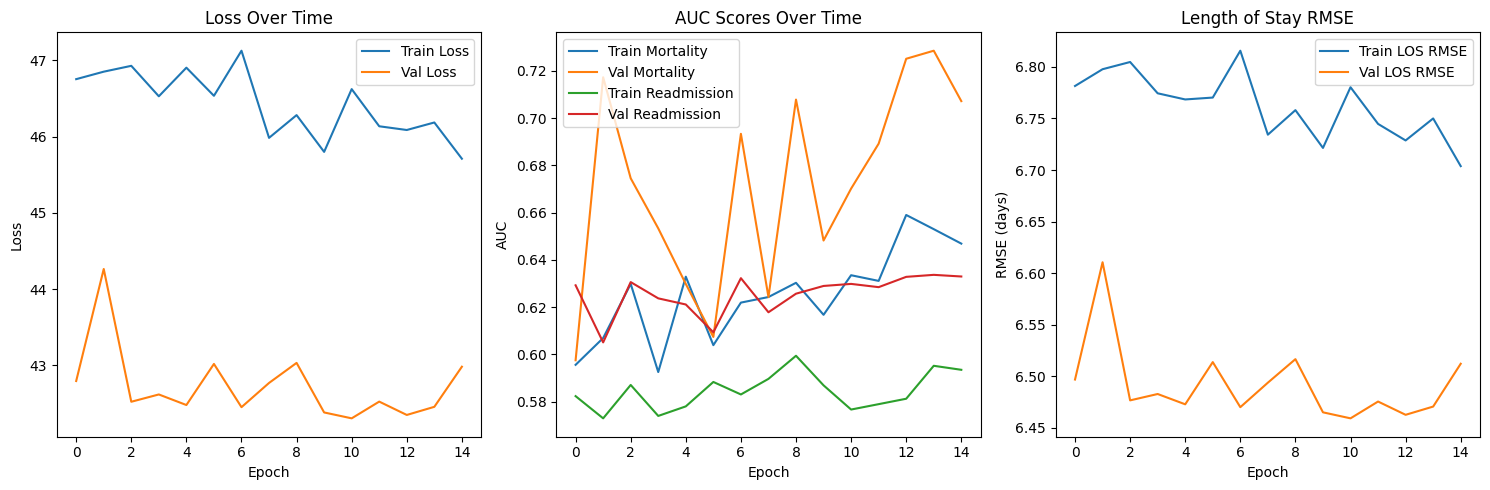

In [ ]:
# Visualization of training progress
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC scores
plt.subplot(1, 3, 2)
plt.plot(history['train_mortality_auc'], label='Train Mortality')
plt.plot(history['val_mortality_auc'], label='Val Mortality')
plt.plot(history['train_readmission_auc'], label='Train Readmission')
plt.plot(history['val_readmission_auc'], label='Val Readmission')
plt.title('AUC Scores Over Time')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot LOS RMSE
plt.subplot(1, 3, 3)
plt.plot(history['train_los_rmse'], label='Train LOS RMSE')
plt.plot(history['val_los_rmse'], label='Val LOS RMSE')
plt.title('Length of Stay RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (days)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#SIMPLE BASELINES


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error

# Prepare data (use only structured features, not embeddings)
structured_cols = [col for col in X_train.columns if col not in ['subject_id', 'discharge_embedding', 'radiology_embedding']]
X_train_structured = X_train[structured_cols]
X_val_structured = X_val[structured_cols]

# 1. Logistic Regression for binary tasks
mortality_lr = LogisticRegression(max_iter=1000)
mortality_lr.fit(X_train_structured, y_train['mortality'])
lr_mortality_preds = mortality_lr.predict_proba(X_val_structured)[:, 1]
lr_mortality_auc = roc_auc_score(y_val['mortality'], lr_mortality_preds)

readmission_lr = LogisticRegression(max_iter=1000)
readmission_lr.fit(X_train_structured, y_train['readmission_30d'])
lr_readmission_preds = readmission_lr.predict_proba(X_val_structured)[:, 1]
lr_readmission_auc = roc_auc_score(y_val['readmission_30d'], lr_readmission_preds)

# 2. Random Forest for LOS
from sklearn.ensemble import RandomForestRegressor
los_rf = RandomForestRegressor(n_estimators=100)
los_rf.fit(X_train_structured, y_train['los_days'])
rf_los_preds = los_rf.predict(X_val_structured)
rf_los_rmse = np.sqrt(mean_squared_error(y_val['los_days'], rf_los_preds))

print("Baseline Results:")
print(f"Logistic Regression - Mortality AUC: {lr_mortality_auc:.4f}")
print(f"Logistic Regression - Readmission AUC: {lr_readmission_auc:.4f}")
print(f"Random Forest - LOS RMSE: {rf_los_rmse:.4f}")

Baseline Results:
Logistic Regression - Mortality AUC: 0.6952
Logistic Regression - Readmission AUC: 0.5191
Random Forest - LOS RMSE: 6.8252


In [ ]:
from sklearn.metrics import roc_auc_score, mean_squared_error
import numpy as np

# 1. Extract text embeddings for each patient (average of discharge and radiology embeddings)
def get_text_only_features():
    # Create numpy arrays from the embeddings we processed earlier
    train_discharge = np.array([emb for emb in train_dataset.discharge_embeddings])
    train_radiology = np.array([emb for emb in train_dataset.radiology_embeddings])

    val_discharge = np.array([emb for emb in val_dataset.discharge_embeddings])
    val_radiology = np.array([emb for emb in val_dataset.radiology_embeddings])

    # Combine discharge and radiology embeddings (average them)
    X_train_text = np.concatenate([train_discharge, train_radiology], axis=1)
    X_val_text = np.concatenate([val_discharge, val_radiology], axis=1)

    return X_train_text, X_val_text

X_train_text, X_val_text = get_text_only_features()

# 2. Train models using only text features
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# Mortality prediction
text_mortality_model = LogisticRegression(max_iter=1000)
text_mortality_model.fit(X_train_text, y_train['mortality'])
text_mortality_preds = text_mortality_model.predict_proba(X_val_text)[:, 1]
text_mortality_auc = roc_auc_score(y_val['mortality'], text_mortality_preds)

# Readmission prediction
text_readmission_model = LogisticRegression(max_iter=1000)
text_readmission_model.fit(X_train_text, y_train['readmission_30d'])
text_readmission_preds = text_readmission_model.predict_proba(X_val_text)[:, 1]
text_readmission_auc = roc_auc_score(y_val['readmission_30d'], text_readmission_preds)

# Length of stay prediction
text_los_model = RandomForestRegressor(n_estimators=100)
text_los_model.fit(X_train_text, y_train['los_days'])
text_los_preds = text_los_model.predict(X_val_text)
text_los_rmse = np.sqrt(mean_squared_error(y_val['los_days'], text_los_preds))

# Print results
print("\nText-Only Model Results:")
print(f"Text-Only - Mortality AUC: {text_mortality_auc:.4f}")
print(f"Text-Only - Readmission AUC: {text_readmission_auc:.4f}")
print(f"Text-Only - LOS RMSE: {text_los_rmse:.4f}")


Text-Only Model Results:
Text-Only - Mortality AUC: 0.7243
Text-Only - Readmission AUC: 0.6616
Text-Only - LOS RMSE: 6.6945



Comparison with Baselines:
                  Model  Mortality AUC  Readmission AUC  LOS RMSE
0   Logistic Regression       0.695235         0.519053       NaN
1         Random Forest            NaN              NaN  6.825223
2             Text-only       0.724307         0.661562  6.694535
3  Our Multi-Task Model       0.728500         0.633600  6.459300


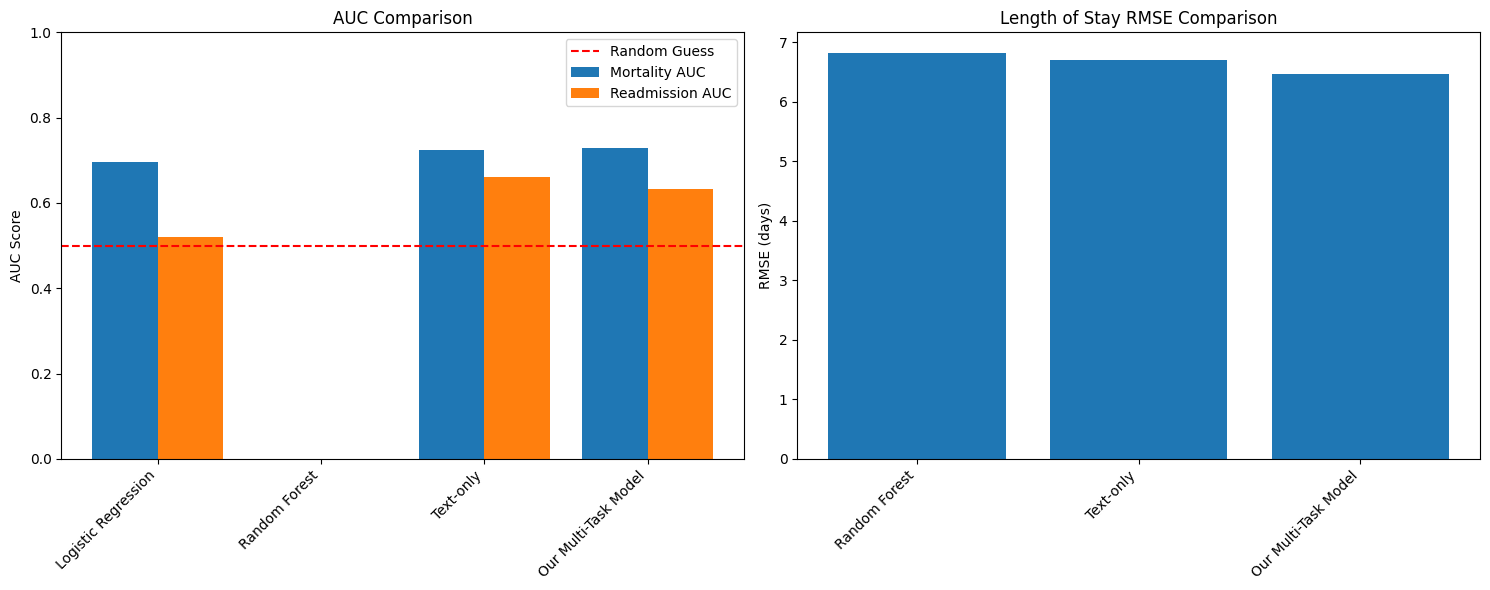

In [ ]:
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'Text-only', 'Our Multi-Task Model'],
    'Mortality AUC': [lr_mortality_auc, np.nan, text_mortality_auc, 0.7285],
    'Readmission AUC': [lr_readmission_auc, np.nan, text_readmission_auc, 0.6336],
    'LOS RMSE': [np.nan, rf_los_rmse, text_los_rmse, 6.4593]
}

results_df = pd.DataFrame(results)
print("\nComparison with Baselines:")
print(results_df)

# Visualizing comparative results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# AUC comparison
plt.subplot(1, 2, 1)
models = results_df['Model']
plt.bar(np.arange(len(models)) - 0.2, results_df['Mortality AUC'], width=0.4, label='Mortality AUC')
plt.bar(np.arange(len(models)) + 0.2, results_df['Readmission AUC'], width=0.4, label='Readmission AUC')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
plt.xticks(np.arange(len(models)), models, rotation=45, ha='right')
plt.ylabel('AUC Score')
plt.title('AUC Comparison')
plt.legend()
plt.ylim(0, 1)

# RMSE comparison
plt.subplot(1, 2, 2)
plt.bar(models, results_df['LOS RMSE'])
plt.ylabel('RMSE (days)')
plt.title('Length of Stay RMSE Comparison')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()